In [ ]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              40
On-line CPU(s) list: 0-39
Thread(s) per core:  2
Core(s) per socket:  20
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0-39
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd i

In [1]:
!pip install 'ethicml[all]'

     |████████████████████████████████| 37.9 MB 1.2 MB/s 
     |████████████████████████████████| 181 kB 88.3 MB/s 
     |████████████████████████████████| 40 kB 6.5 MB/s 
     |████████████████████████████████| 4.3 MB 74.8 MB/s 
     |████████████████████████████████| 3.9 MB 73.7 MB/s 
     |████████████████████████████████| 21.2 MB 38.2 MB/s 
     |████████████████████████████████| 175 kB 85.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 2.1 MB 87.7 MB/s 
     |████████████████████████████████| 8.8 MB 81.7 MB/s 
     |████████████████████████████████| 564 kB 85.8 MB/s 
     |████████████████████████████████| 461 kB 86.8 MB/s 
  Created wheel for typed-argument-parser: filename=typed_argument_parser-1.7.2-py3-none-any.whl size=22701 sha256=f399623294a8ce76b01319985072ce824c197ae8497ce20d290ef4cd26db4970
  Stored in directory: /root/.cache/pip/wheels/ab/9e/09/716b41e56484cac4752e0a6f5a2526ea439c4474bcf5032a7c
  Created wheel for 

##Functions for Tasks

In [2]:
%matplotlib inline
import ethicml as em
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from operator import itemgetter

In [3]:
def TrainTestSplit(dataSet, label):
  df=pd.DataFrame()
  for col in dataSet.x.columns:
    df[col]=dataSet.x[col]
  df[dataSet.s.columns[0]]=dataSet.s[dataSet.s.columns[0]]
  df[dataSet.y.columns[0]]=dataSet.y[dataSet.y.columns[0]]
  X=df.drop(labels=[label],axis=1)
  y=df[label]
  return X,y

In [4]:
def crossValidationWithSenstiveAttribute(X_train, y_train, sensitiveAttribute, weights=pd.DataFrame()):
  params = {
          "C": [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5] #Regularization parameter for LogisticRegression
        }
  #Accuracy and fairness metrics across 5Folds
  k = 5
  kf = StratifiedKFold(n_splits=k)
  ModelList=[]

  for param in params['C']:
    acc_em=[]
    eoopFairness=[]
    clfLogistic = LogisticRegression(random_state=1, C=param, solver='liblinear')

    if(weights.empty):
      for train_index , test_index in kf.split(X_train, y_train): #Here X_train contains the sensitive attribute
        X_tr , X_te = X_train.loc[train_index,:], X_train.loc[test_index,:]
        y_tr , y_te = y_train.loc[train_index], y_train.loc[test_index]
        #Create an EthicML tuple format to paas it in the fairness metric measurment
        testTuple = em.DataTuple(pd.DataFrame(X_te.drop(labels=[sensitiveAttribute],axis=1)).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(X_te[sensitiveAttribute]).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(y_te).reset_index().drop(labels=['index'],axis=1))

        clfLogistic.fit(X_tr, y_tr)
        predictions = em.Prediction(pd.Series(clfLogistic.predict(X_te), name="Preds"))

        acc_em.append(sum(predictions.hard.reset_index(drop=True)==y_te.reset_index(drop=True))/len(y_te))

        tpr_per_sens = em.metric_per_sensitive_attribute(predictions, testTuple, em.TPR())
        eoopFairness.append(em.diff_per_sensitive_attribute(tpr_per_sens))


    else: #This condition is for task 2 when weights are passed.
      for train_index , test_index in kf.split(X_train, y_train):
        X_tr , X_te = X_train.loc[train_index,:], X_train.loc[test_index,:]
        y_tr , y_te = y_train.loc[train_index], y_train.loc[test_index]
        X_weights=weights['instance weights'].loc[train_index]
        testTuple = em.DataTuple(pd.DataFrame(X_te.drop(labels=[sensitiveAttribute],axis=1)).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(X_te[sensitiveAttribute]).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(y_te).reset_index().drop(labels=['index'],axis=1))

        clfLogistic.fit(X_tr, y_tr, sample_weight=X_weights)
        predictions = em.Prediction(pd.Series(clfLogistic.predict(X_te), name="Preds"))

        acc_em.append(sum(predictions.hard.reset_index(drop=True)==y_te.reset_index(drop=True))/len(y_te))

        tpr_per_sens = em.metric_per_sensitive_attribute(predictions, testTuple, em.TPR())
        eoopFairness.append(em.diff_per_sensitive_attribute(tpr_per_sens))

    avg_acc_score_em = sum(acc_em)/k

    fairnessTotal=0
    dispTotal=0
    for fairnessDict in eoopFairness:
      for key,value in fairnessDict.items():
        fairnessTotal+=value
    ModelList.append((avg_acc_score_em, fairnessTotal/len(eoopFairness), param))
  return ModelList

In [5]:
def crossValidationWithoutSenstiveAttribute(train, weights=pd.DataFrame()):
  params = {
        "C": [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
      }
  #Fairness metrics across 5Folds
  k = 5
  kf = StratifiedKFold(n_splits=k)
  ModelList=[] #Model list for every hyperparameter (total 7)

  for param in params['C']:
    acc_em=[]
    eoopFairness=[] #Equality of opportunity fairness
    clfLogistic = LogisticRegression(random_state=1, C=param, solver='liblinear')

    if(weights.empty):
      for train_index , test_index in kf.split(train.x, train.y): #train.x does not contain sensitive attribute
        X_tr , X_te = train.x.loc[train_index,:], train.x.loc[test_index,:]
        y_tr , y_te = train.y.loc[train_index], train.y.loc[test_index]
        X_teS = train.s.loc[test_index] 
        testTuple = em.DataTuple(pd.DataFrame(X_te).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(X_teS).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(y_te).reset_index().drop(labels=['index'],axis=1))

        clfLogistic.fit(X_tr, y_tr)
        predictions = em.Prediction(pd.Series(clfLogistic.predict(X_te), name="Preds"))

        acc_em.append(sum(predictions.hard.reset_index(drop=True)==y_te[y_te.columns[0]].reset_index(drop=True))/len(y_te))

        tpr_per_sens = em.metric_per_sensitive_attribute(predictions, testTuple, em.TPR())
        eoopFairness.append(em.diff_per_sensitive_attribute(tpr_per_sens))

    else:
      for train_index , test_index in kf.split(train.x, train.y):
        X_tr , X_te = train.x.loc[train_index,:], train.x.loc[test_index,:]
        y_tr , y_te = train.y.loc[train_index], train.y.loc[test_index]
        X_teS = train.s.loc[test_index] 
        X_weights=weights['instance weights'].loc[train_index]
        testTuple = em.DataTuple(pd.DataFrame(X_te).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(X_teS).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(y_te).reset_index().drop(labels=['index'],axis=1))

        clfLogistic.fit(X_tr, y_tr, sample_weight=X_weights)
        predictions = em.Prediction(pd.Series(clfLogistic.predict(X_te), name="Preds"))

        acc_em.append(sum(predictions.hard.reset_index(drop=True)==y_te[y_te.columns[0]].reset_index(drop=True))/len(y_te))

        tpr_per_sens = em.metric_per_sensitive_attribute(predictions, testTuple, em.TPR())
        eoopFairness.append(em.diff_per_sensitive_attribute(tpr_per_sens))

    avg_acc_score_em = sum(acc_em)/k

    fairnessTotal=0
    for fairnessDict in eoopFairness:
      for key,value in fairnessDict.items():
        fairnessTotal+=value
    ModelList.append((avg_acc_score_em, fairnessTotal/len(eoopFairness), param))
  return ModelList

In [6]:
def plotGraph(ModelList):
  plt.style.use('seaborn-whitegrid')
  CVal=[]
  FVal=[]
  accVal=[]
  for acc,fness,param in ModelList:
    CVal.append(str(param))
    FVal.append(fness)
    accVal.append(acc)
  
  colors = FVal
  plt.figure(dpi=500)
  plt.scatter(CVal, accVal, c=colors, s=100, alpha=0.8, cmap='viridis')
  plt.xlabel("Trade-off hyperparameter C",labelpad=7)
  plt.ylabel("Accuracy",labelpad=7)
  plt.colorbar(label="Equality of Opportunity fairness metric",orientation='horizontal').ax.invert_xaxis()

In [7]:
def getBestAccuracyModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, ModelList, weights=pd.DataFrame()):
  c=max(ModelList)[2] #Maximum of accuracy of all the models
  clfLogisticTest = LogisticRegression(random_state=1, C=c, solver='liblinear')

  if(weights.empty):
    clfLogisticTest.fit(X_train, y_train)
  else:
    clfLogisticTest.fit(X_train, y_train, sample_weight=weights['instance weights'])

  print("Model with hyperparameter C =", c)
  predictionsTest = em.Prediction(pd.Series(clfLogisticTest.predict(X_test), name="Preds"))
  print("Test Set Accuracy", sum(predictionsTest.hard.reset_index(drop=True)==y_test.reset_index(drop=True))/len(y_test))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTest, test, em.TPR())
  print("Fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))

def getBestAccuracyModelWithoutSenstiveAttribute(train, test, ModelList, weights=pd.DataFrame()):
  c=max(ModelList)[2]
  clfLogisticTest = LogisticRegression(random_state=1, C=c, solver='liblinear')

  if(weights.empty):
    clfLogisticTest.fit(train.x, train.y)
  else:
    clfLogisticTest.fit(train.x, train.y, sample_weight=weights['instance weights'])

  print("Model with hyperparameter C =", c)
  predictionsTest = em.Prediction(pd.Series(clfLogisticTest.predict(test.x), name="Preds"))
  print("Test Set Accuracy", sum(predictionsTest.hard.reset_index(drop=True)==test.y[test.y.columns[0]].reset_index(drop=True))/len(test.y))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTest, test, em.TPR())
  print("Fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))


def getBestFarinessModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, ModelList, weights=pd.DataFrame()):
  c=min(ModelList, key=itemgetter(1))[2] #Minimum of the fairness from all the models
  clfLogisticTest = LogisticRegression(random_state=1, C=c, solver='liblinear')

  if(weights.empty):
    clfLogisticTest.fit(X_train, y_train)
  else:
    clfLogisticTest.fit(X_train, y_train, sample_weight=weights['instance weights'])

  print("Model with hyperparameter C =", c)
  predictionsTest = em.Prediction(pd.Series(clfLogisticTest.predict(X_test), name="Preds"))
  print("Test Set Accuracy", sum(predictionsTest.hard.reset_index(drop=True)==y_test.reset_index(drop=True))/len(y_test))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTest, test, em.TPR())
  print("Fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))

def getBestFarinessModelWithoutSenstiveAttribute(train, test, ModelList, weights=pd.DataFrame()):
  c=min(ModelList, key=itemgetter(1))[2]
  clfLogisticTest = LogisticRegression(random_state=1, C=c, solver='liblinear')

  if(weights.empty):
    clfLogisticTest.fit(train.x, train.y)
  else:
    clfLogisticTest.fit(train.x, train.y, sample_weight=weights['instance weights'])

  print("Model with hyperparameter C =", c)
  predictionsTest = em.Prediction(pd.Series(clfLogisticTest.predict(test.x), name="Preds"))
  print("Test Set Accuracy", sum(predictionsTest.hard.reset_index(drop=True)==test.y[test.y.columns[0]].reset_index(drop=True))/len(test.y))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTest, test, em.TPR())
  print("Fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))


In [8]:
def getBestAccuracyAndFairnessWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelT1, modelT2, weights):
  tradeOffScore=[]
  for i in range(len(modelT1)):
    tradeOffScore.append(((modelT1[i][0] - modelT2[i][0]) * np.abs((modelT1[i][1] - modelT2[i][1])),modelT1[i][2])) #Subtracting accuracies and fairness and multiplying them

  bestParam=(max(tradeOffScore),tradeOffScore.index(max(tradeOffScore)))
  model5=modelT1[bestParam[1]]
  model6=modelT2[bestParam[1]]
  print("Models with hyperparameter C =", model5[2])
#--------------------------------------------------------------------------------------------------------------------------------------
  clfLogisticTest = LogisticRegression(random_state=1, C=model5[2], solver='liblinear')
  clfLogisticTest.fit(X_train, y_train)

  predictionsTest = em.Prediction(pd.Series(clfLogisticTest.predict(X_test), name="Preds"))
  print("Standard ML Model (5) test Accuracy", sum(predictionsTest.hard.reset_index(drop=True)==y_test.reset_index(drop=True))/len(y_test))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTest, test, em.TPR())
  print("Standard ML Model (5) fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))
#---------------------------------------------------------------------------------------------------------------------------------------
  clfLogisticTestFair = LogisticRegression(random_state=1, C=model6[2], solver='liblinear')
  clfLogisticTestFair.fit(X_train, y_train, sample_weight=weights['instance weights'])

  predictionsTestFair = em.Prediction(pd.Series(clfLogisticTestFair.predict(X_test), name="Preds"))
  print("Fairness based ML Model (6) test Accuracy", sum(predictionsTestFair.hard.reset_index(drop=True)==y_test.reset_index(drop=True))/len(y_test))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTestFair, test, em.TPR())
  print("Fairness based ML Model (6) fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))


def getBestAccuracyAndFairnessWithoutSenstiveAttribute(train, test, modelT1, modelT2, weights):
  tradeOffScore=[]
  for i in range(len(modelT1)):
    tradeOffScore.append(((modelT1[i][0] - modelT2[i][0]) * np.abs((modelT1[i][1] - modelT2[i][1])),modelT1[i][2]))

  bestParam=(max(tradeOffScore),tradeOffScore.index(max(tradeOffScore)))
  model5=modelT1[bestParam[1]]
  model6=modelT2[bestParam[1]]
  print("Models with hyperparameter C =", model5[2])
#--------------------------------------------------------------------------------------------------------------------------------------
  clfLogisticTest = LogisticRegression(random_state=1, C=model5[2], solver='liblinear')
  clfLogisticTest.fit(train.x, train.y)

  predictionsTest = em.Prediction(pd.Series(clfLogisticTest.predict(test.x), name="Preds"))
  print("Standard ML Model (5) test Accuracy", sum(predictionsTest.hard.reset_index(drop=True)==test.y[test.y.columns[0]].reset_index(drop=True))/len(y_test))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTest, test, em.TPR())
  print("Standard ML Model (5) fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))
#---------------------------------------------------------------------------------------------------------------------------------------
  clfLogisticTestFair = LogisticRegression(random_state=1, C=model6[2], solver='liblinear')
  clfLogisticTestFair.fit(train.x, train.y, sample_weight=weights['instance weights'])

  predictionsTestFair = em.Prediction(pd.Series(clfLogisticTestFair.predict(test.x), name="Preds"))
  print("Fairness based ML Model (6) test Accuracy", sum(predictionsTestFair.hard.reset_index(drop=True)==test.y[test.y.columns[0]].reset_index(drop=True))/len(y_test))

  tpr_per_sens = em.metric_per_sensitive_attribute(predictionsTestFair, test, em.TPR())
  print("Fairness based ML Model (6) fairness metrics on test set",em.diff_per_sensitive_attribute(tpr_per_sens))

#Adult Dataset

##Dataset imports

In [9]:
dataset = em.adult(split="Sex",binarize_nationality=True)
data = dataset.load()
train, test = em.train_test_split(data, train_percentage=0.7)
scale_orig = StandardScaler()
train.x[dataset.continuous_features] = scale_orig.fit_transform(train.x[dataset.continuous_features])
test.x[dataset.continuous_features] = scale_orig.transform(test.x[dataset.continuous_features])

X_train, y_train = TrainTestSplit(train, 'salary_>50K')
X_test, y_test = TrainTestSplit(test, 'salary_>50K')

In [10]:
df=pd.DataFrame()
for col in data.x.columns:
  df[col]=data.x[col]
df[data.s.columns[0]]=data.s[data.s.columns[0]]
df[data.y.columns[0]]=data.y[data.y.columns[0]]

(array([34014.,     0., 11208.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

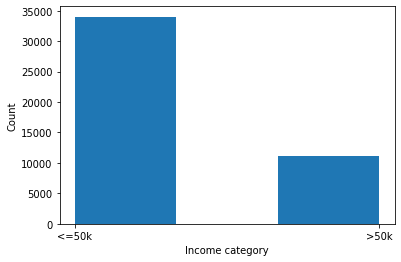

In [11]:
salaryList=[">50k" if s==1 else "<=50k" for s in data.y['salary_>50K']]
plt.xlabel('Income category')
plt.ylabel('Count')
plt.hist(salaryList,bins=3)

The number of <=50k salary receivers is much higher as compared to the number of >50k salary receivers. This is bound to bias the model as it will be more accuracte in predicting the former data points as compared to later.

(array([30527.,     0., 14695.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

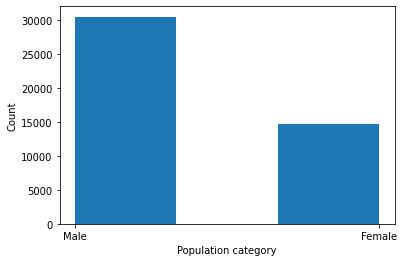

In [12]:
genderList=["Male" if s==1 else "Female" for s in data.s['sex_Male']]
plt.xlabel('Population category')
plt.ylabel('Count')
plt.hist(genderList,bins=3)

As we can observe that the dataset is very imbalanced. The number of males are double as compared to the number of females. This is bound to bias the model as it will be more accuracte in predicting the male data points as compared to females.

(array([13026.,     0.,  1669.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

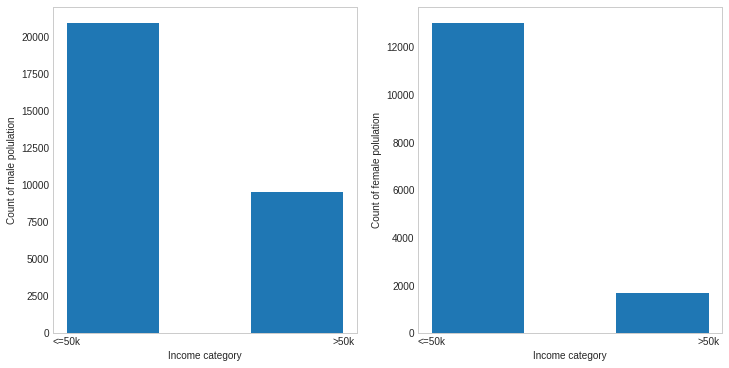

In [ ]:
from IPython.core.pylabtools import figsize
maleDf=df[df.sex_Male==1]
malesalaryList=[">50k" if s==1 else "<=50k" for s in maleDf['salary_>50K']]
femaleDf=df[df.sex_Male==0]
femalesalaryList=[">50k" if s==1 else "<=50k" for s in femaleDf['salary_>50K']]

fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].set_ylabel("Count of male polulation")
ax[0].set_xlabel("Income category")
ax[0].grid()
ax[0].hist(malesalaryList,bins=3)
ax[1].set_ylabel("Count of female polulation")
ax[1].set_xlabel("Income category")
ax[1].grid()
ax[1].hist(femalesalaryList,bins=3)

We can observe that the ratio of the male population earning more than 50k is about 50% whereas the same ratio of the female population is about 15%.


##Task 1 (training with sensitive attribute)

In [ ]:
modelListT1 = crossValidationWithSenstiveAttribute(X_train, y_train, sensitiveAttribute='sex_Male')
print(modelListT1)

[(0.8465329331859106, 0.10494226067632077, 10), (0.8465329331859106, 0.10404369222780377, 1), (0.8466592955299321, 0.10965797189606626, 0.1), (0.8447006791975991, 0.14286749301378127, 0.01), (0.8290633391249408, 0.1996928096216827, 0.001), (0.7895119254462171, 0.07170763250484904, 0.0001), (0.76076449218133, 0.01214057488308212, 1e-05)]


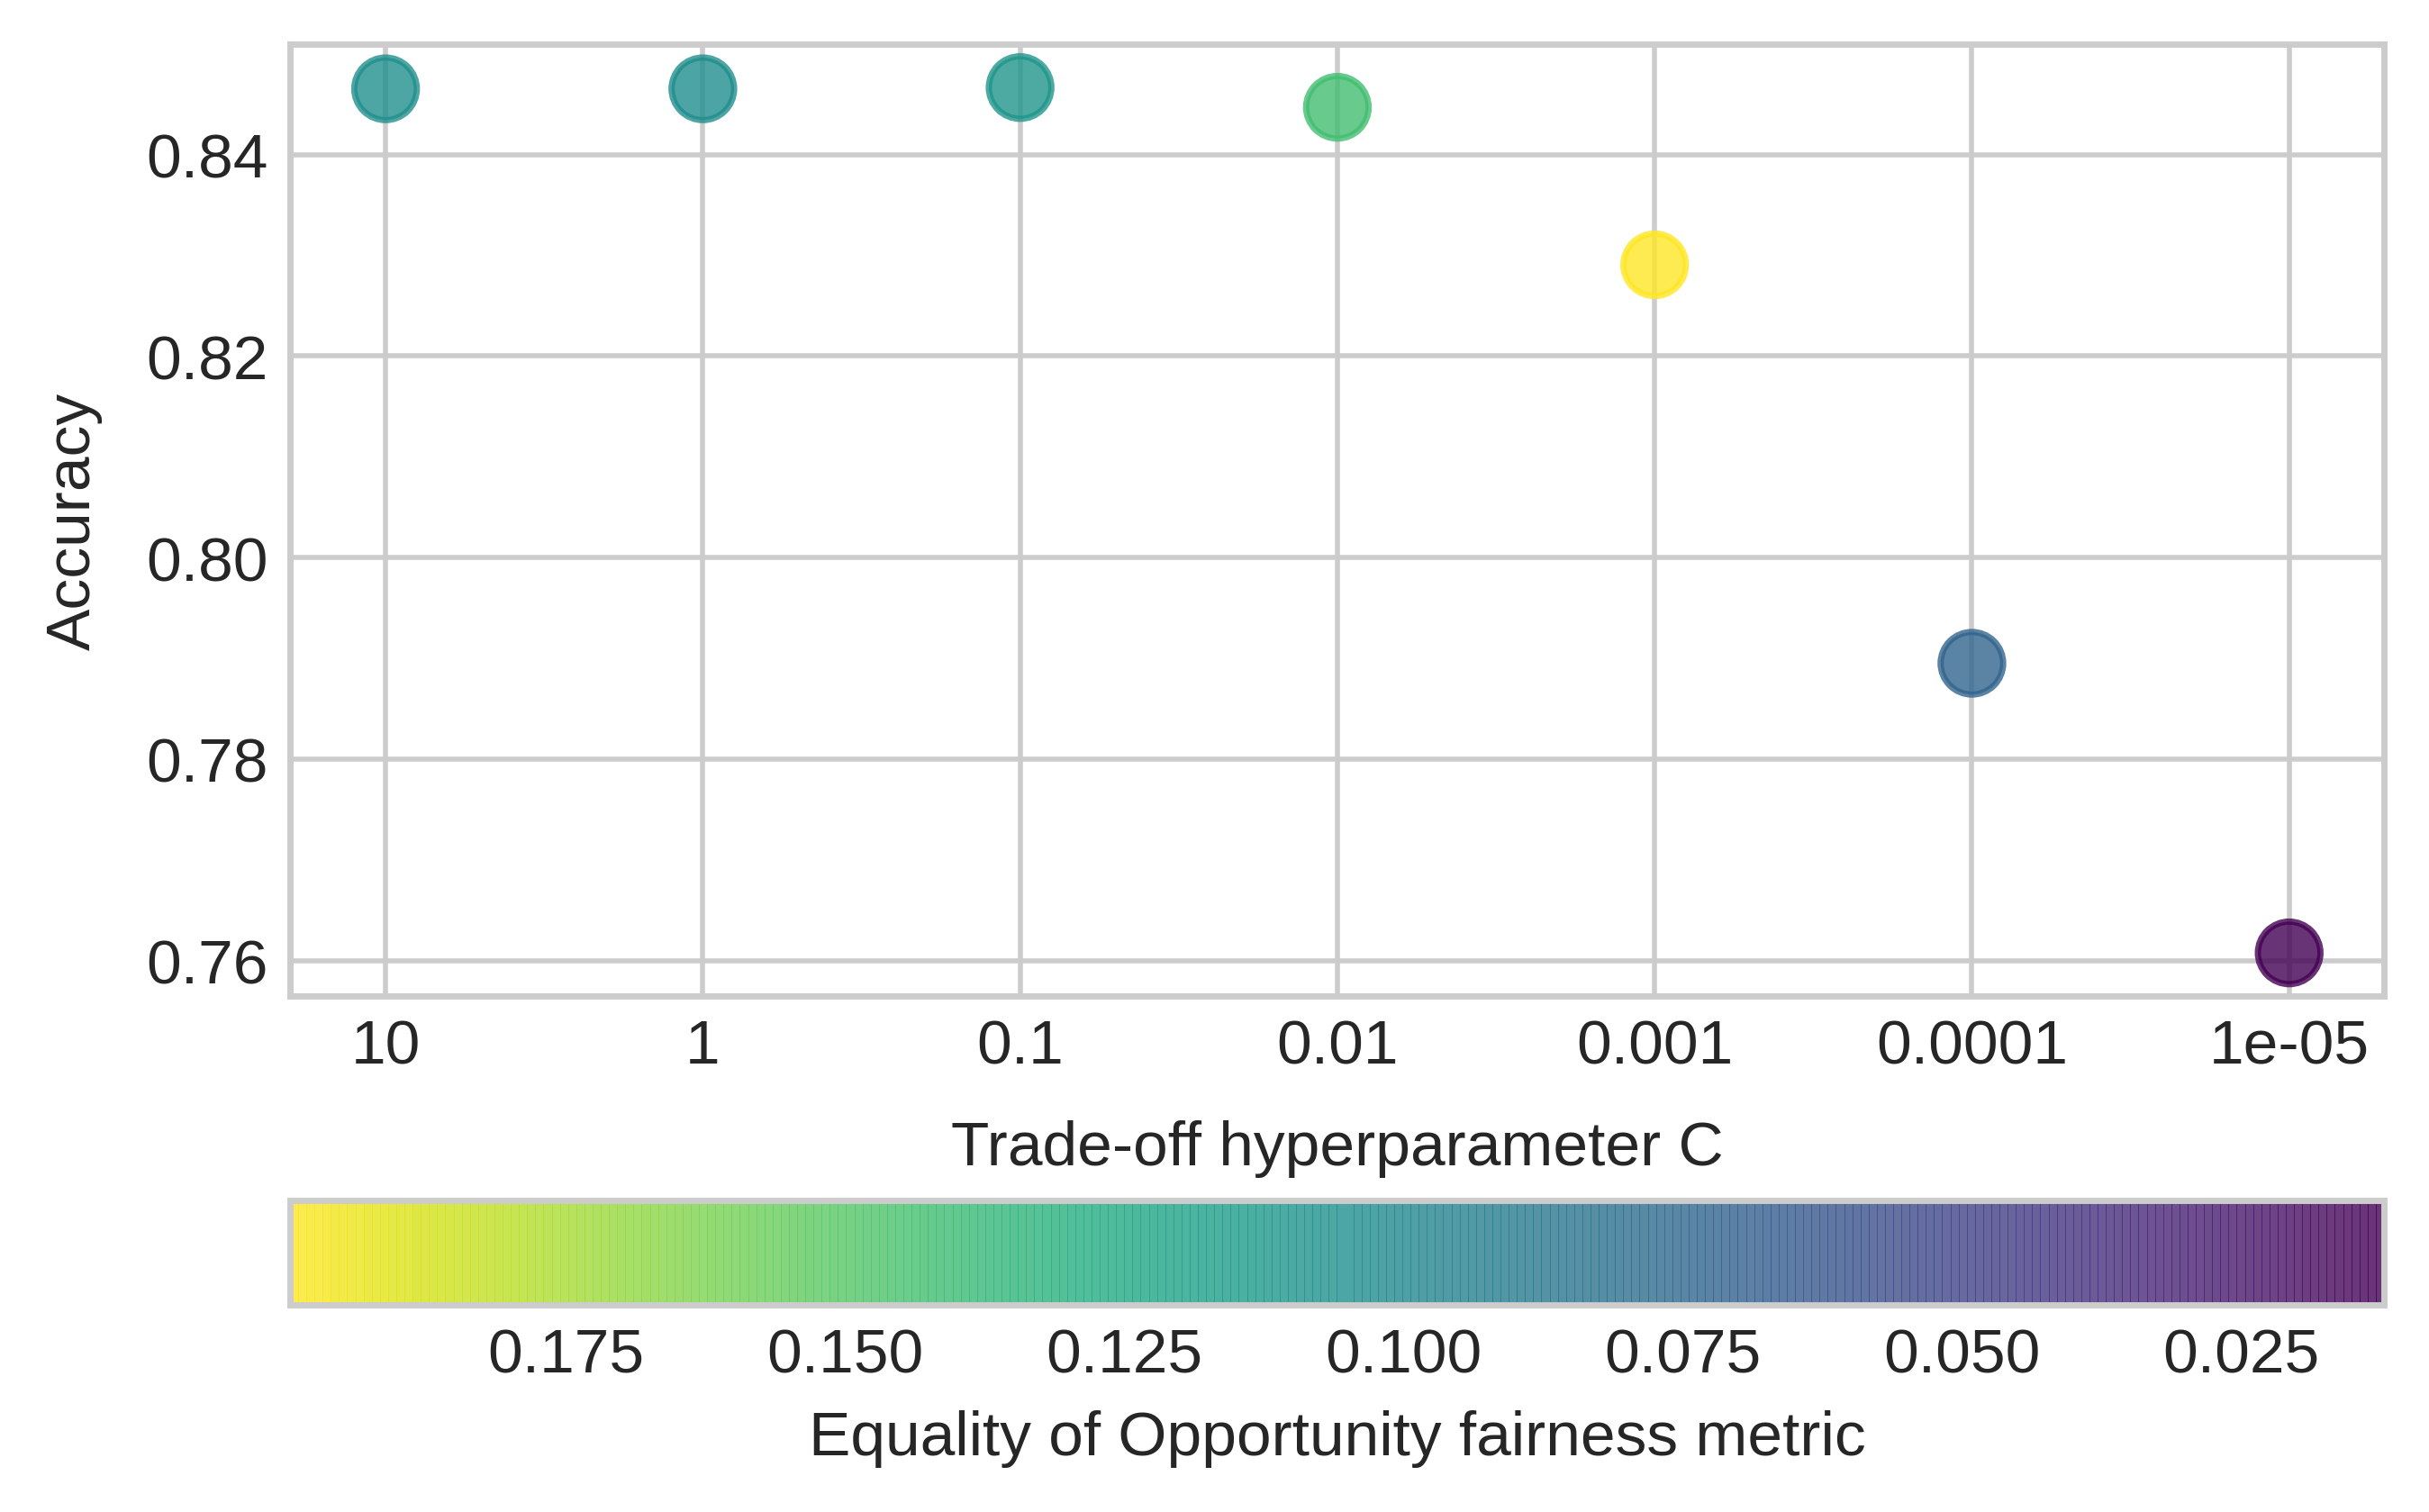

In [ ]:
plotGraph(modelListT1)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 0.1
Test Set Accuracy 0.8477924375322473
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.11064877472859735}


In [ ]:
#Best fairness model
getBestFarinessModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 1e-05
Test Set Accuracy 0.7614800619149407
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.0073602672272295305}


The results suggest that the best fairness model is less accurate but better generalized. Hence it is more fair than the best accuracy model.

##Task2 Reweighing (training with sensitive attributes)

In [ ]:
#Reweighing the dataset

In [ ]:
weights=em.compute_instance_weights(train)

In [ ]:
weights.head()

,instance weights
0,1.094795
1,1.094795
2,1.094795
3,0.792144
4,0.848966


In [ ]:
modelListT2 = crossValidationWithSenstiveAttribute(X_train, y_train, sensitiveAttribute='sex_Male', weights=weights)
print(modelListT2)

[(0.8407518559469278, 0.1465747892979498, 10), (0.8406254936029065, 0.14869582634447798, 1), (0.8409098088769547, 0.14456355851686706, 0.1), (0.838635286684568, 0.13343646587548402, 0.01), (0.8252724688042964, 0.03590105854502677, 0.001), (0.7818354130469121, 0.03192237518214129, 0.0001), (0.7590901911230454, 0.012861004620936312, 1e-05)]


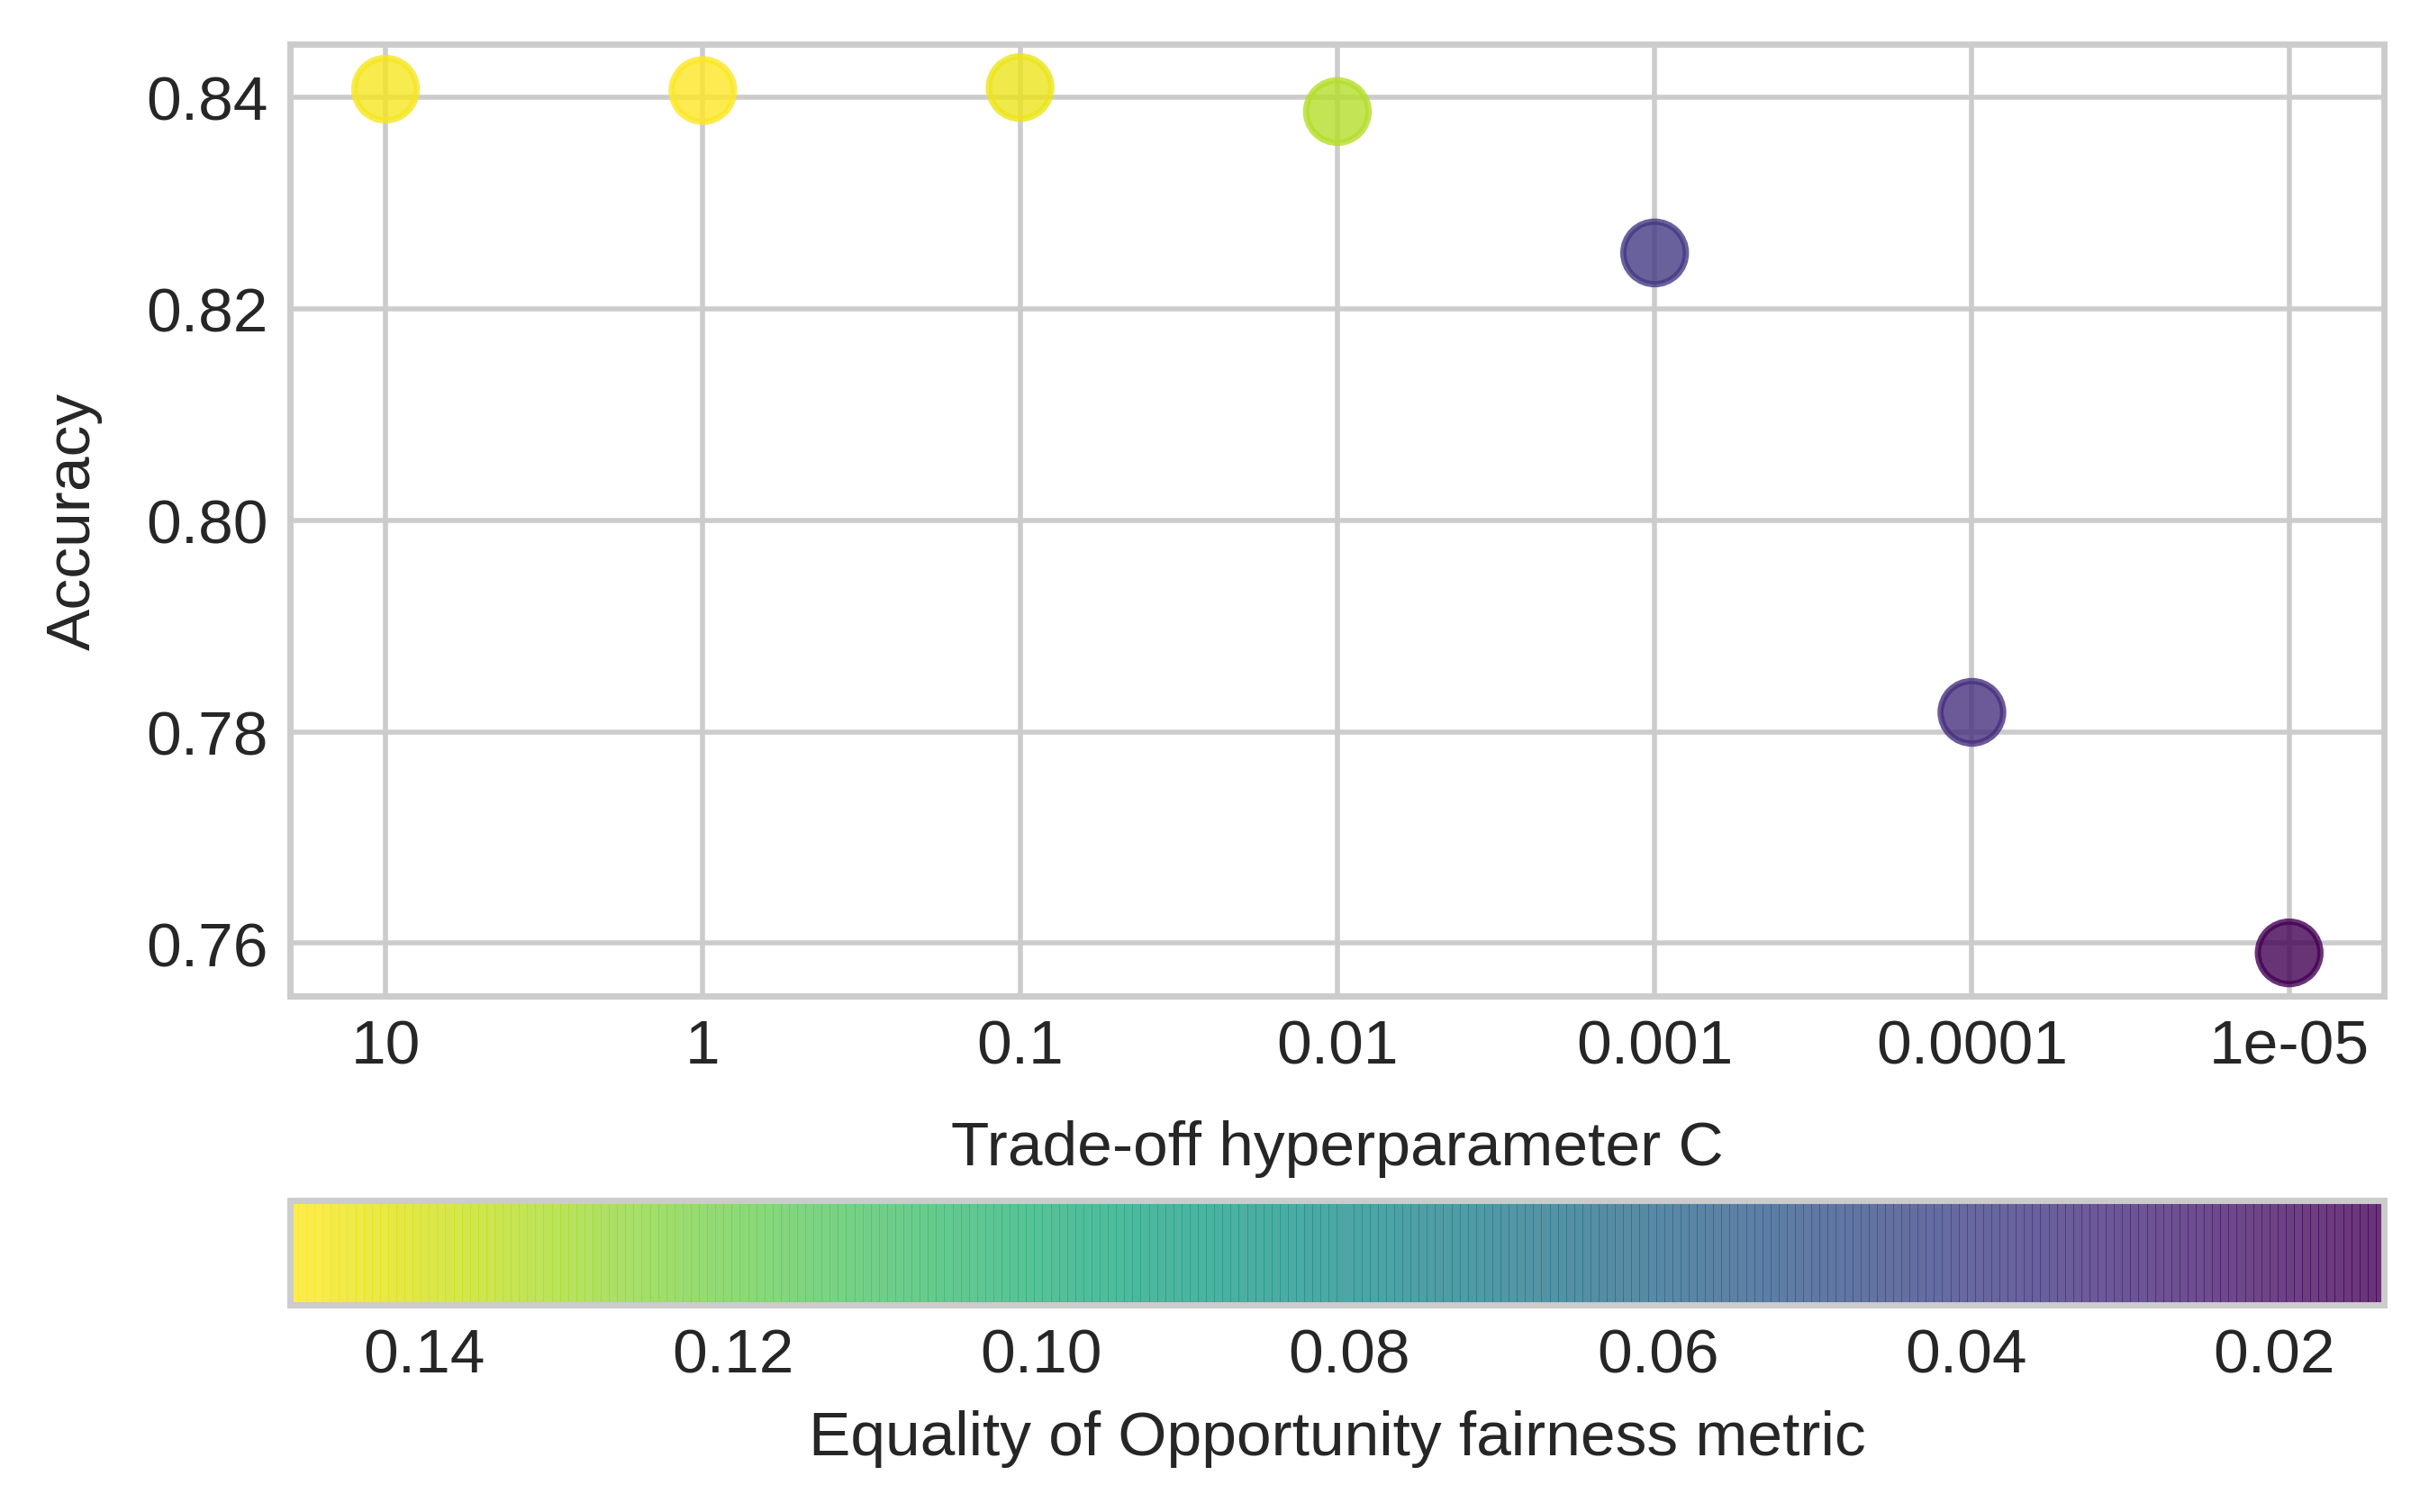

In [ ]:
plotGraph(modelListT2)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT2, weights)

Model with hyperparameter C = 0.1
Test Set Accuracy 0.8443281491855237
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.15302646355861438}


In [ ]:
#Best fairness model
getBestFarinessModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT2, weights)

Model with hyperparameter C = 1e-05
Test Set Accuracy 0.7596373553475344
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.004810378091974547}


##Task 3 (trained with sensitive attributes) accounting for both accuracy and fairness criteria:
Subtract accuracy of both standrad and fairness based model and multiply with the difference of fairness of both the models for each hyperparameter. Finally, select the hyperparameter with the highest value and the model with fairness closest to zero.

In [ ]:
getBestAccuracyAndFairnessWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1, modelListT2, weights)

Models with hyperparameter C = 0.001
Standard ML Model (5) test Accuracy 0.832534827154124
Standard ML Model (5) fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.2276154001209434}
Fairness based ML Model (6) test Accuracy 0.8336404510945677
Fairness based ML Model (6) fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.039794684251447}


##Task 1 (training without sensitive attribute)

In [ ]:
modelListT1 = crossValidationWithoutSenstiveAttribute(train)
print(modelListT1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[(0.8459643026378139, 0.0824111063912708, 10), (0.8463117990838731, 0.08219783558480265, 1), (0.8460590743958301, 0.08980043613389396, 0.1), (0.8443847733375455, 0.12972229243179406, 0.01), (0.8290317485389354, 0.2027530357418162, 0.001), (0.7915021323645555, 0.10759742012576753, 0.0001), (0.762817880271679, 0.02148698976784421, 1e-05)]


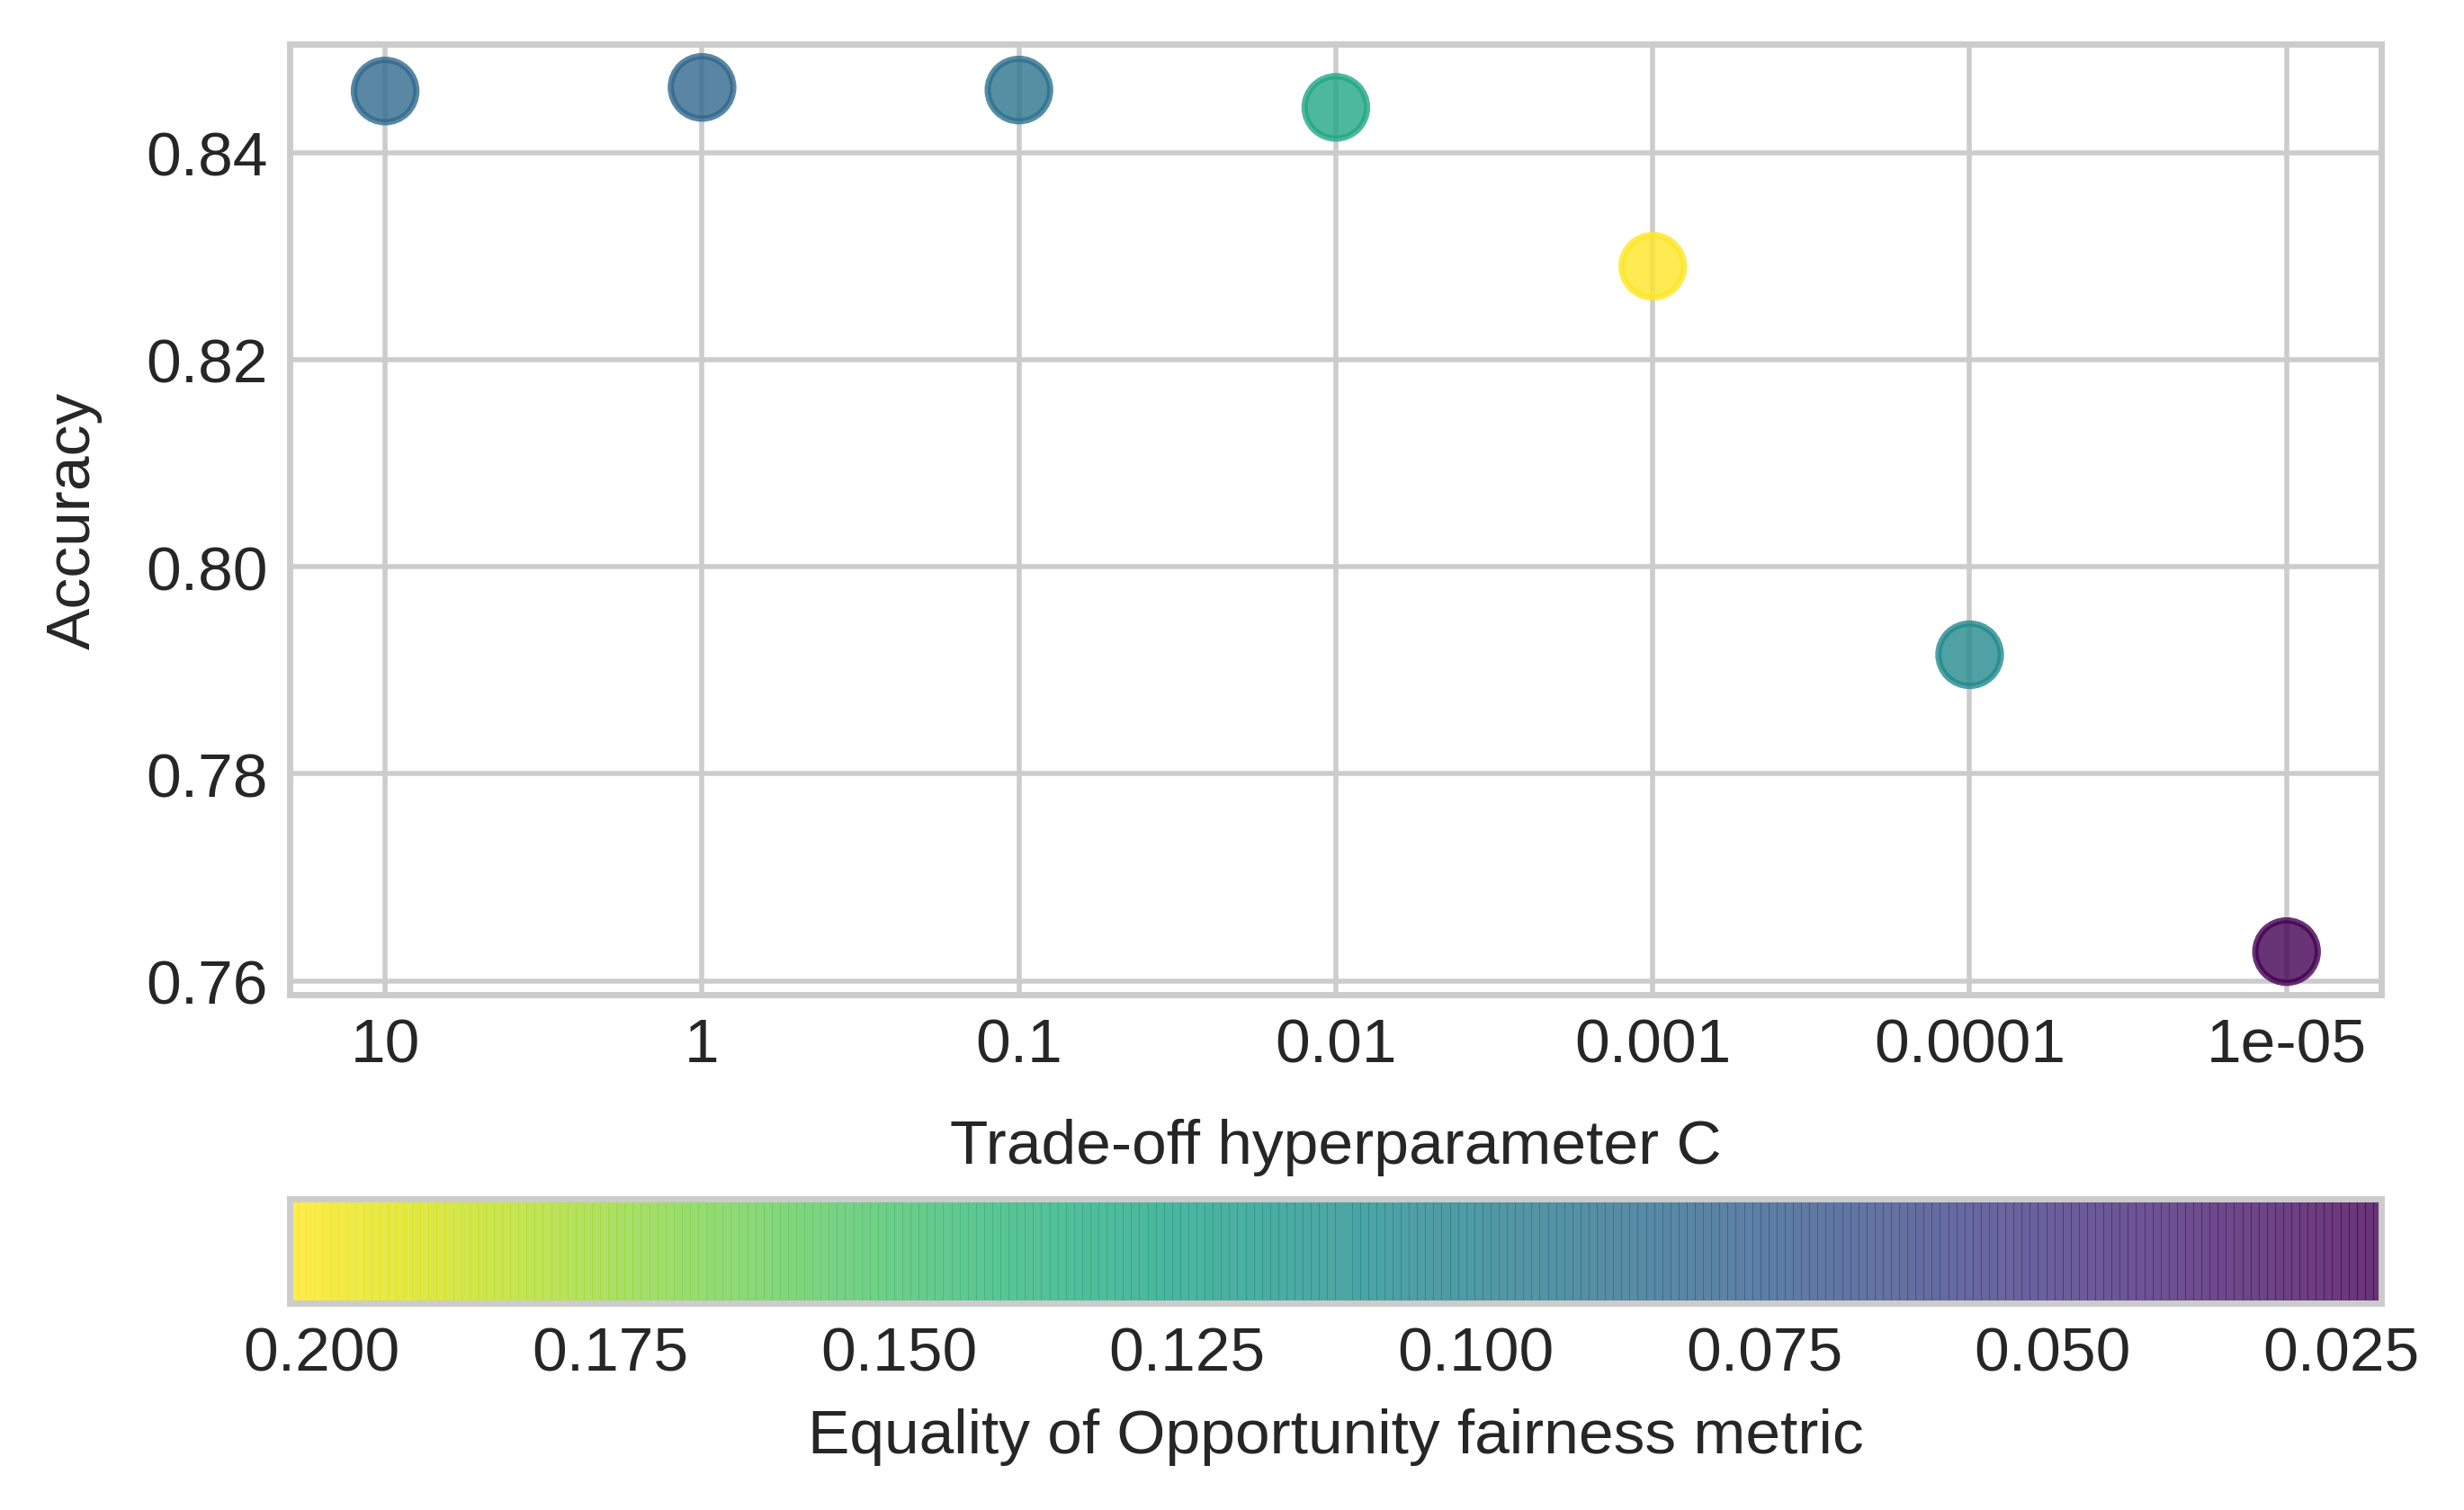

In [ ]:
plotGraph(modelListT1)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithoutSenstiveAttribute(train, test, modelListT1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with hyperparameter C = 1
Test Set Accuracy 0.8485295201592098
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.0865277737783281}


In [ ]:
#Best fairness model
getBestFarinessModelWithoutSenstiveAttribute(train, test, modelListT1)

Model with hyperparameter C = 1e-05
Test Set Accuracy 0.7636913097958281
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.021969936936677516}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Task2 Reweighing (training without sensitive attributes)

In [ ]:
modelListT2 = crossValidationWithoutSenstiveAttribute(train, weights=weights)
print(modelListT2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[(0.8416048017690729, 0.13317885466703314, 10), (0.8415416205970621, 0.13263603395328172, 1), (0.8414152582530405, 0.12761416664031439, 0.1), (0.8407518559469278, 0.10025851332662361, 0.01), (0.8266624545885326, 0.031218136915225746, 0.001), (0.7866371821197283, 0.039660737001089, 0.0001), (0.7612067603854051, 0.012332340642851918, 1e-05)]


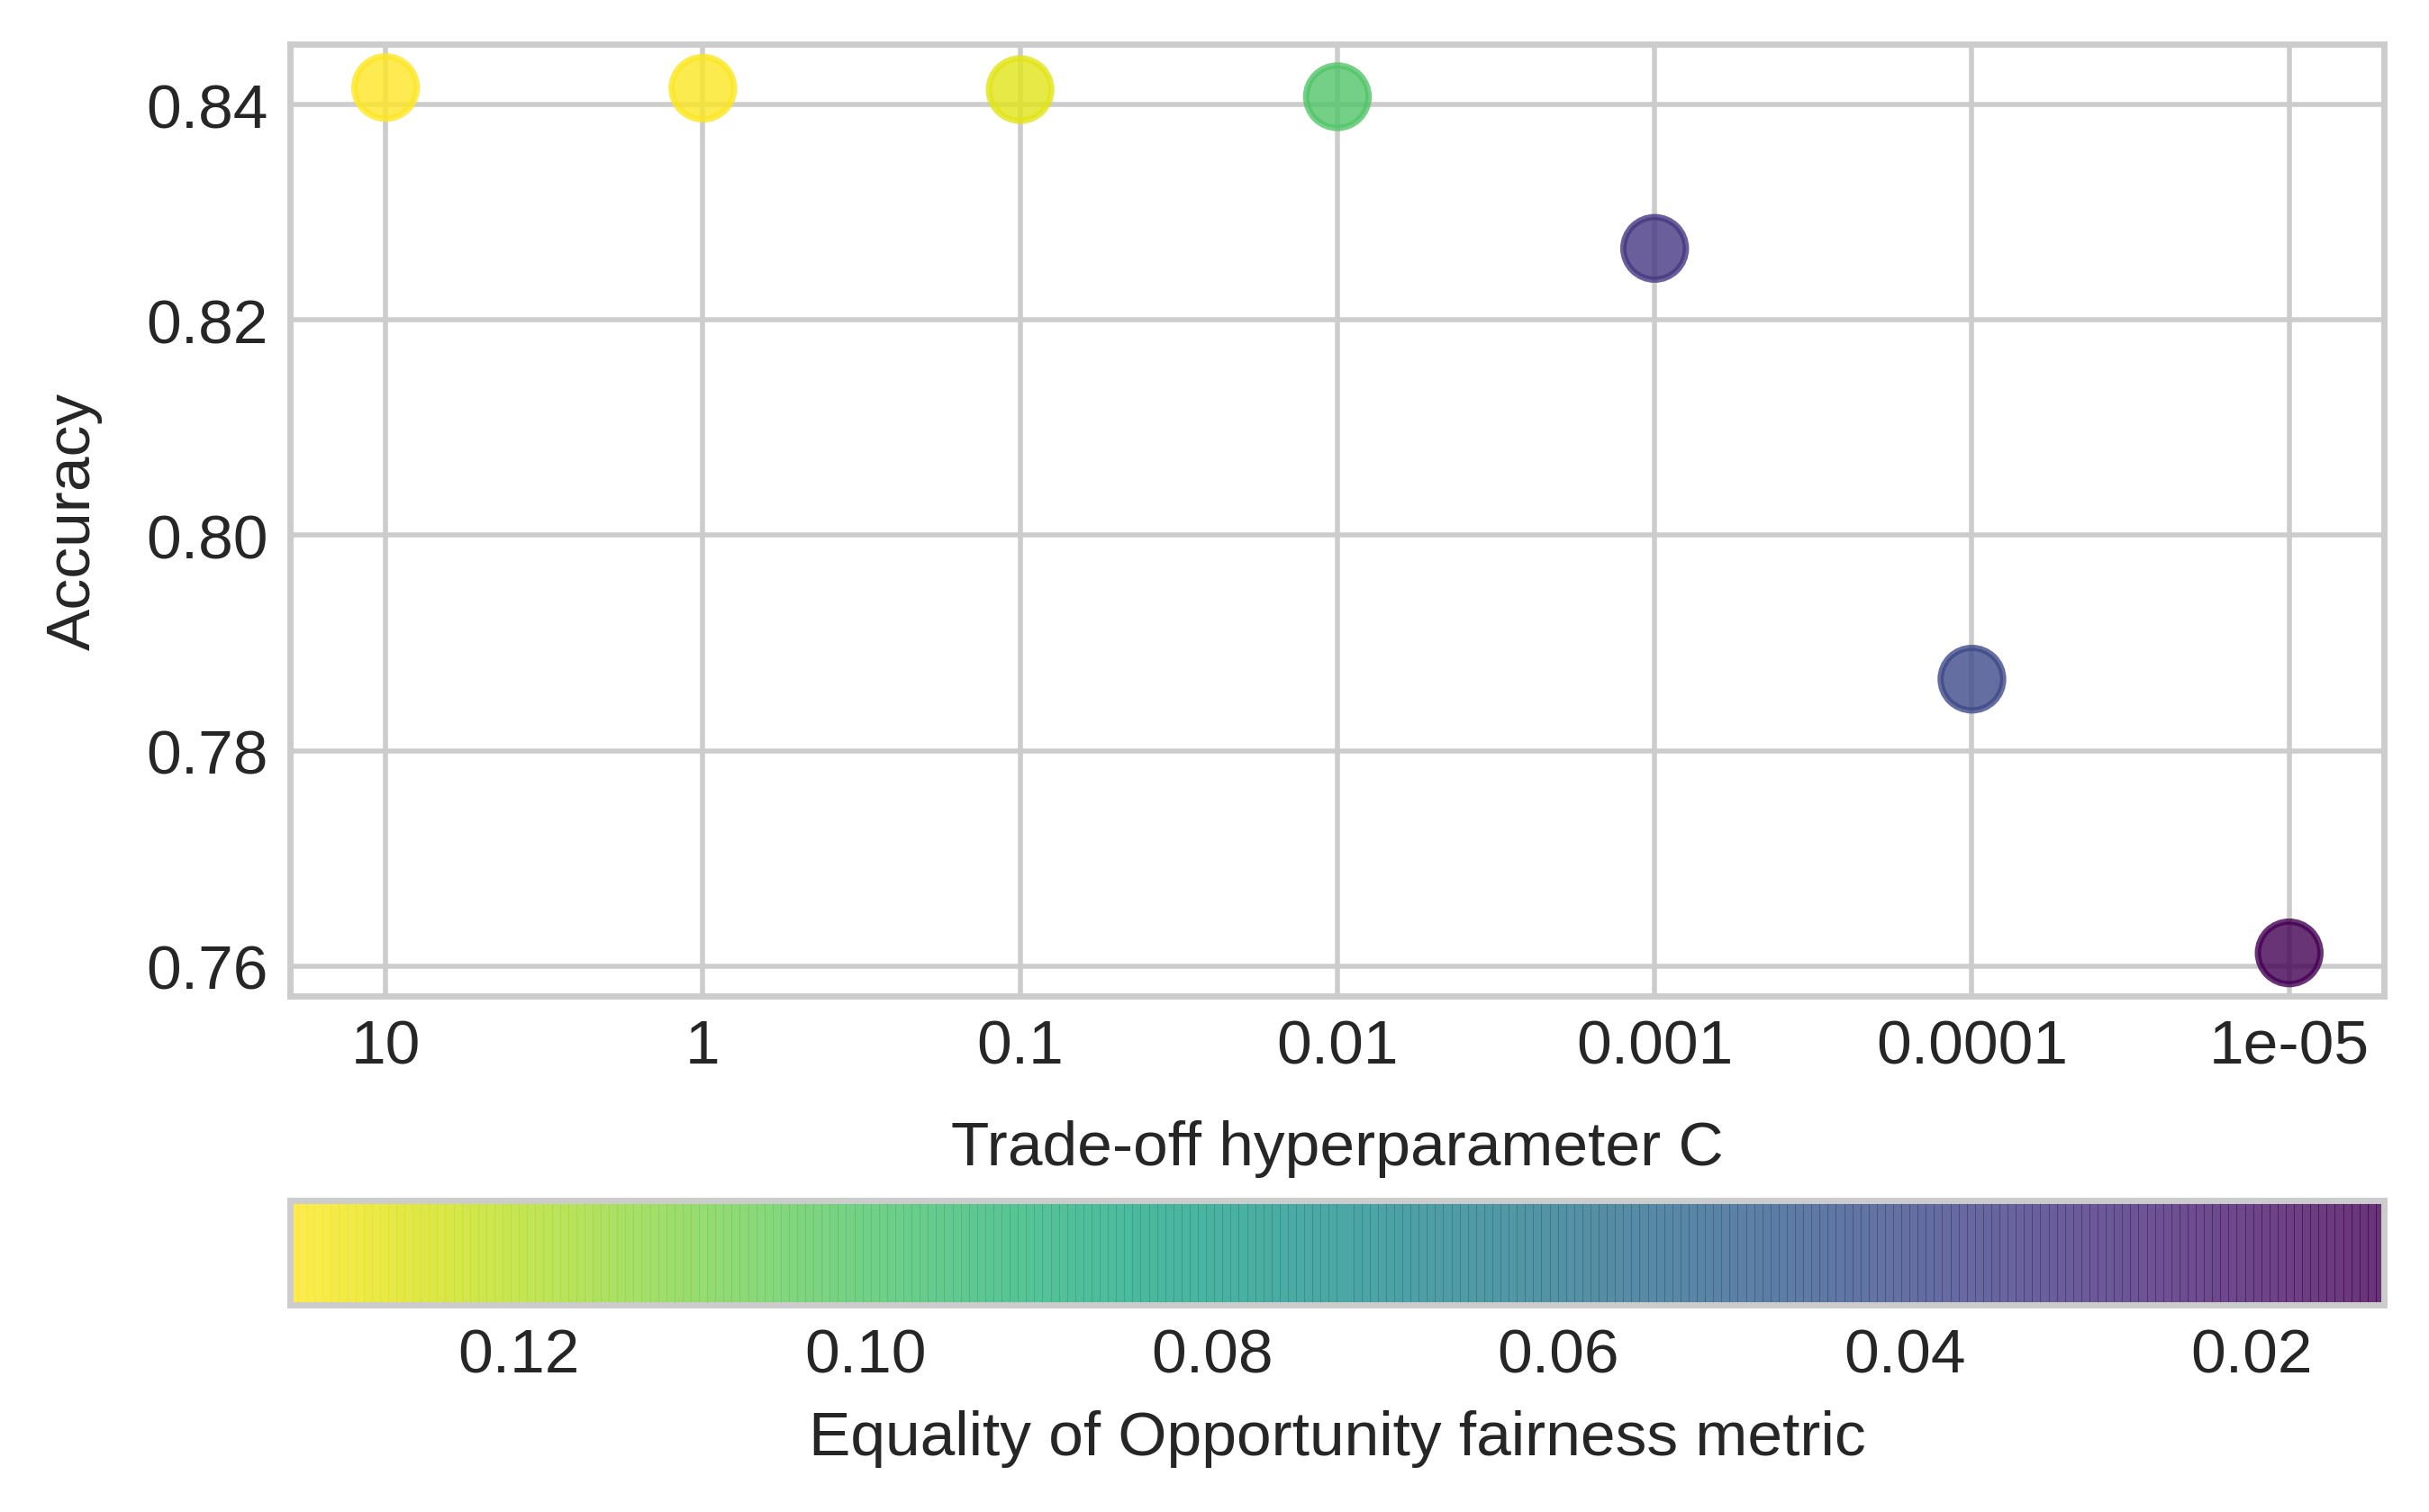

In [ ]:
plotGraph(modelListT2)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithoutSenstiveAttribute(train, test, modelListT2, weights)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with hyperparameter C = 10
Test Set Accuracy 0.8437384830839537
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.13366112822875575}


In [ ]:
#Best fairness model
getBestFarinessModelWithoutSenstiveAttribute(train, test, modelListT2, weights)

Model with hyperparameter C = 1e-05
Test Set Accuracy 0.7620697280165106
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.011193019840469949}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Task 3 (trained without sensitive attributes) accounting for both accuracy and fairness criteria:
Subtract accuracy of both standrad and fairness based model and multiply with the difference of fairness of both the models for each hyperparameter. Finally, select the hyperparameter with the highest value and the model with fairness closest to zero.

In [ ]:
getBestAccuracyAndFairnessWithoutSenstiveAttribute(train, test, modelListT1, modelListT2, weights)

Models with hyperparameter C = 0.001


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Standard ML Model (5) test Accuracy 0.832534827154124
Standard ML Model (5) fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.2276154001209434}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fairness based ML Model (6) test Accuracy 0.8342301171961377
Fairness based ML Model (6) fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.00347856134995822}


#Extra task: Counterfactual Augmentation on Adult Dataset

##Dataset Manuplulation

In [ ]:
dataset = em.adult(split="Sex",binarize_nationality=True)
data = dataset.load()

In [ ]:
df=pd.DataFrame()
for col in data.x.columns:
  df[col]=data.x[col]
df[data.s.columns[0]]=data.s[data.s.columns[0]]
df[data.y.columns[0]]=data.y[data.y.columns[0]]

In [ ]:
df_out = df.copy()
df_out['sex_Male'] = df_out['sex_Male'].apply(lambda value: 1-value)
result = pd.concat([df.copy(), df_out])

(array([68028.,     0., 22416.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

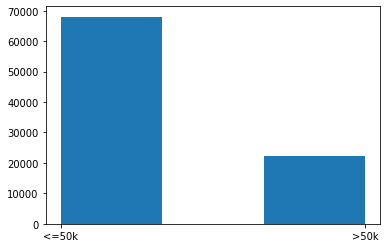

In [ ]:
salaryList=[">50k" if s==1 else "<=50k" for s in result['salary_>50K']]
plt.hist(salaryList,bins=3)

(array([45222.,     0., 45222.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

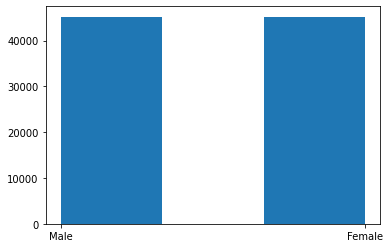

In [ ]:
genderList=["Male" if s==1 else "Female" for s in result['sex_Male']]
plt.hist(genderList,bins=3)

Dataset is balanced

(array([34014.,     0., 11208.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

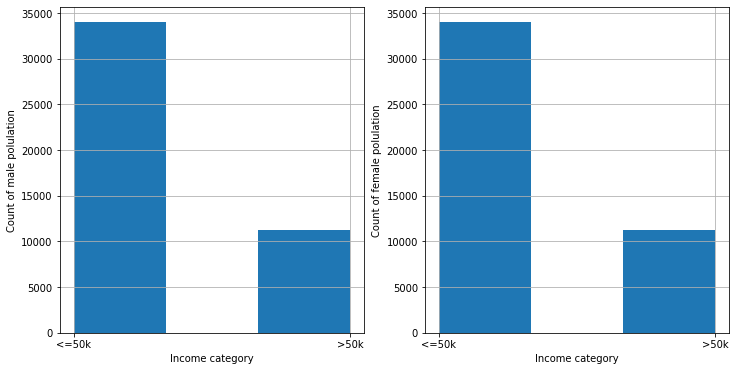

In [ ]:
from IPython.core.pylabtools import figsize
maleDf=result[result.sex_Male==1]
malesalaryList=[">50k" if s==1 else "<=50k" for s in maleDf['salary_>50K']]
femaleDf=result[result.sex_Male==0]
femalesalaryList=[">50k" if s==1 else "<=50k" for s in femaleDf['salary_>50K']]

fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].set_ylabel("Count of male polulation")
ax[0].set_xlabel("Income category")
ax[0].grid()
ax[0].hist(malesalaryList,bins=3)
ax[1].set_ylabel("Count of female polulation")
ax[1].set_xlabel("Income category")
ax[1].grid()
ax[1].hist(femalesalaryList,bins=3)

All the bias is gone

In [ ]:
cfData = em.DataTuple(pd.DataFrame(result.drop(labels=['sex_Male'],axis=1).drop(labels=['salary_>50K'],axis=1)).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(result['sex_Male']).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(result['salary_>50K']).reset_index().drop(labels=['index'],axis=1))

In [ ]:
train, test = em.train_test_split(cfData, train_percentage=0.7)
scale_orig = StandardScaler()
train.x[dataset.continuous_features] = scale_orig.fit_transform(train.x[dataset.continuous_features])
test.x[dataset.continuous_features] = scale_orig.transform(test.x[dataset.continuous_features])

X_train, y_train = TrainTestSplit(train, 'salary_>50K')
X_test, y_test = TrainTestSplit(test, 'salary_>50K')


##Task 1 (training with sensitive attribute)

A comparison of different values for regularization parameter ‘alpha’ on synthetic datasets. The plot shows that different alphas yield different decision functions.

Alpha is a parameter for regularization term, aka penalty term, that combats overfitting by constraining the size of the weights. Increasing alpha may fix high variance (a sign of overfitting) by encouraging smaller weights, resulting in a decision boundary plot that appears with lesser curvatures. Similarly, decreasing alpha may fix high bias (a sign of underfitting) by encouraging larger weights, potentially resulting in a more complicated decision boundary.



In [ ]:
modelListT1 = crossValidationWithSenstiveAttribute(X_train, y_train, sensitiveAttribute='sex_Male')
print(modelListT1)

[(0.8479861001421577, 0.01197530102932196, 10), (0.8480334860211658, 0.011711445916411201, 1), (0.8480492813141683, 0.01256103983083139, 0.1), (0.847164744906018, 0.01622834922062919, 0.01), (0.8379718843784552, 0.038679547507568565, 0.001), (0.8084030958774285, 0.06721133888719313, 0.0001), (0.7664507976622966, 0.020917512838196102, 1e-05)]


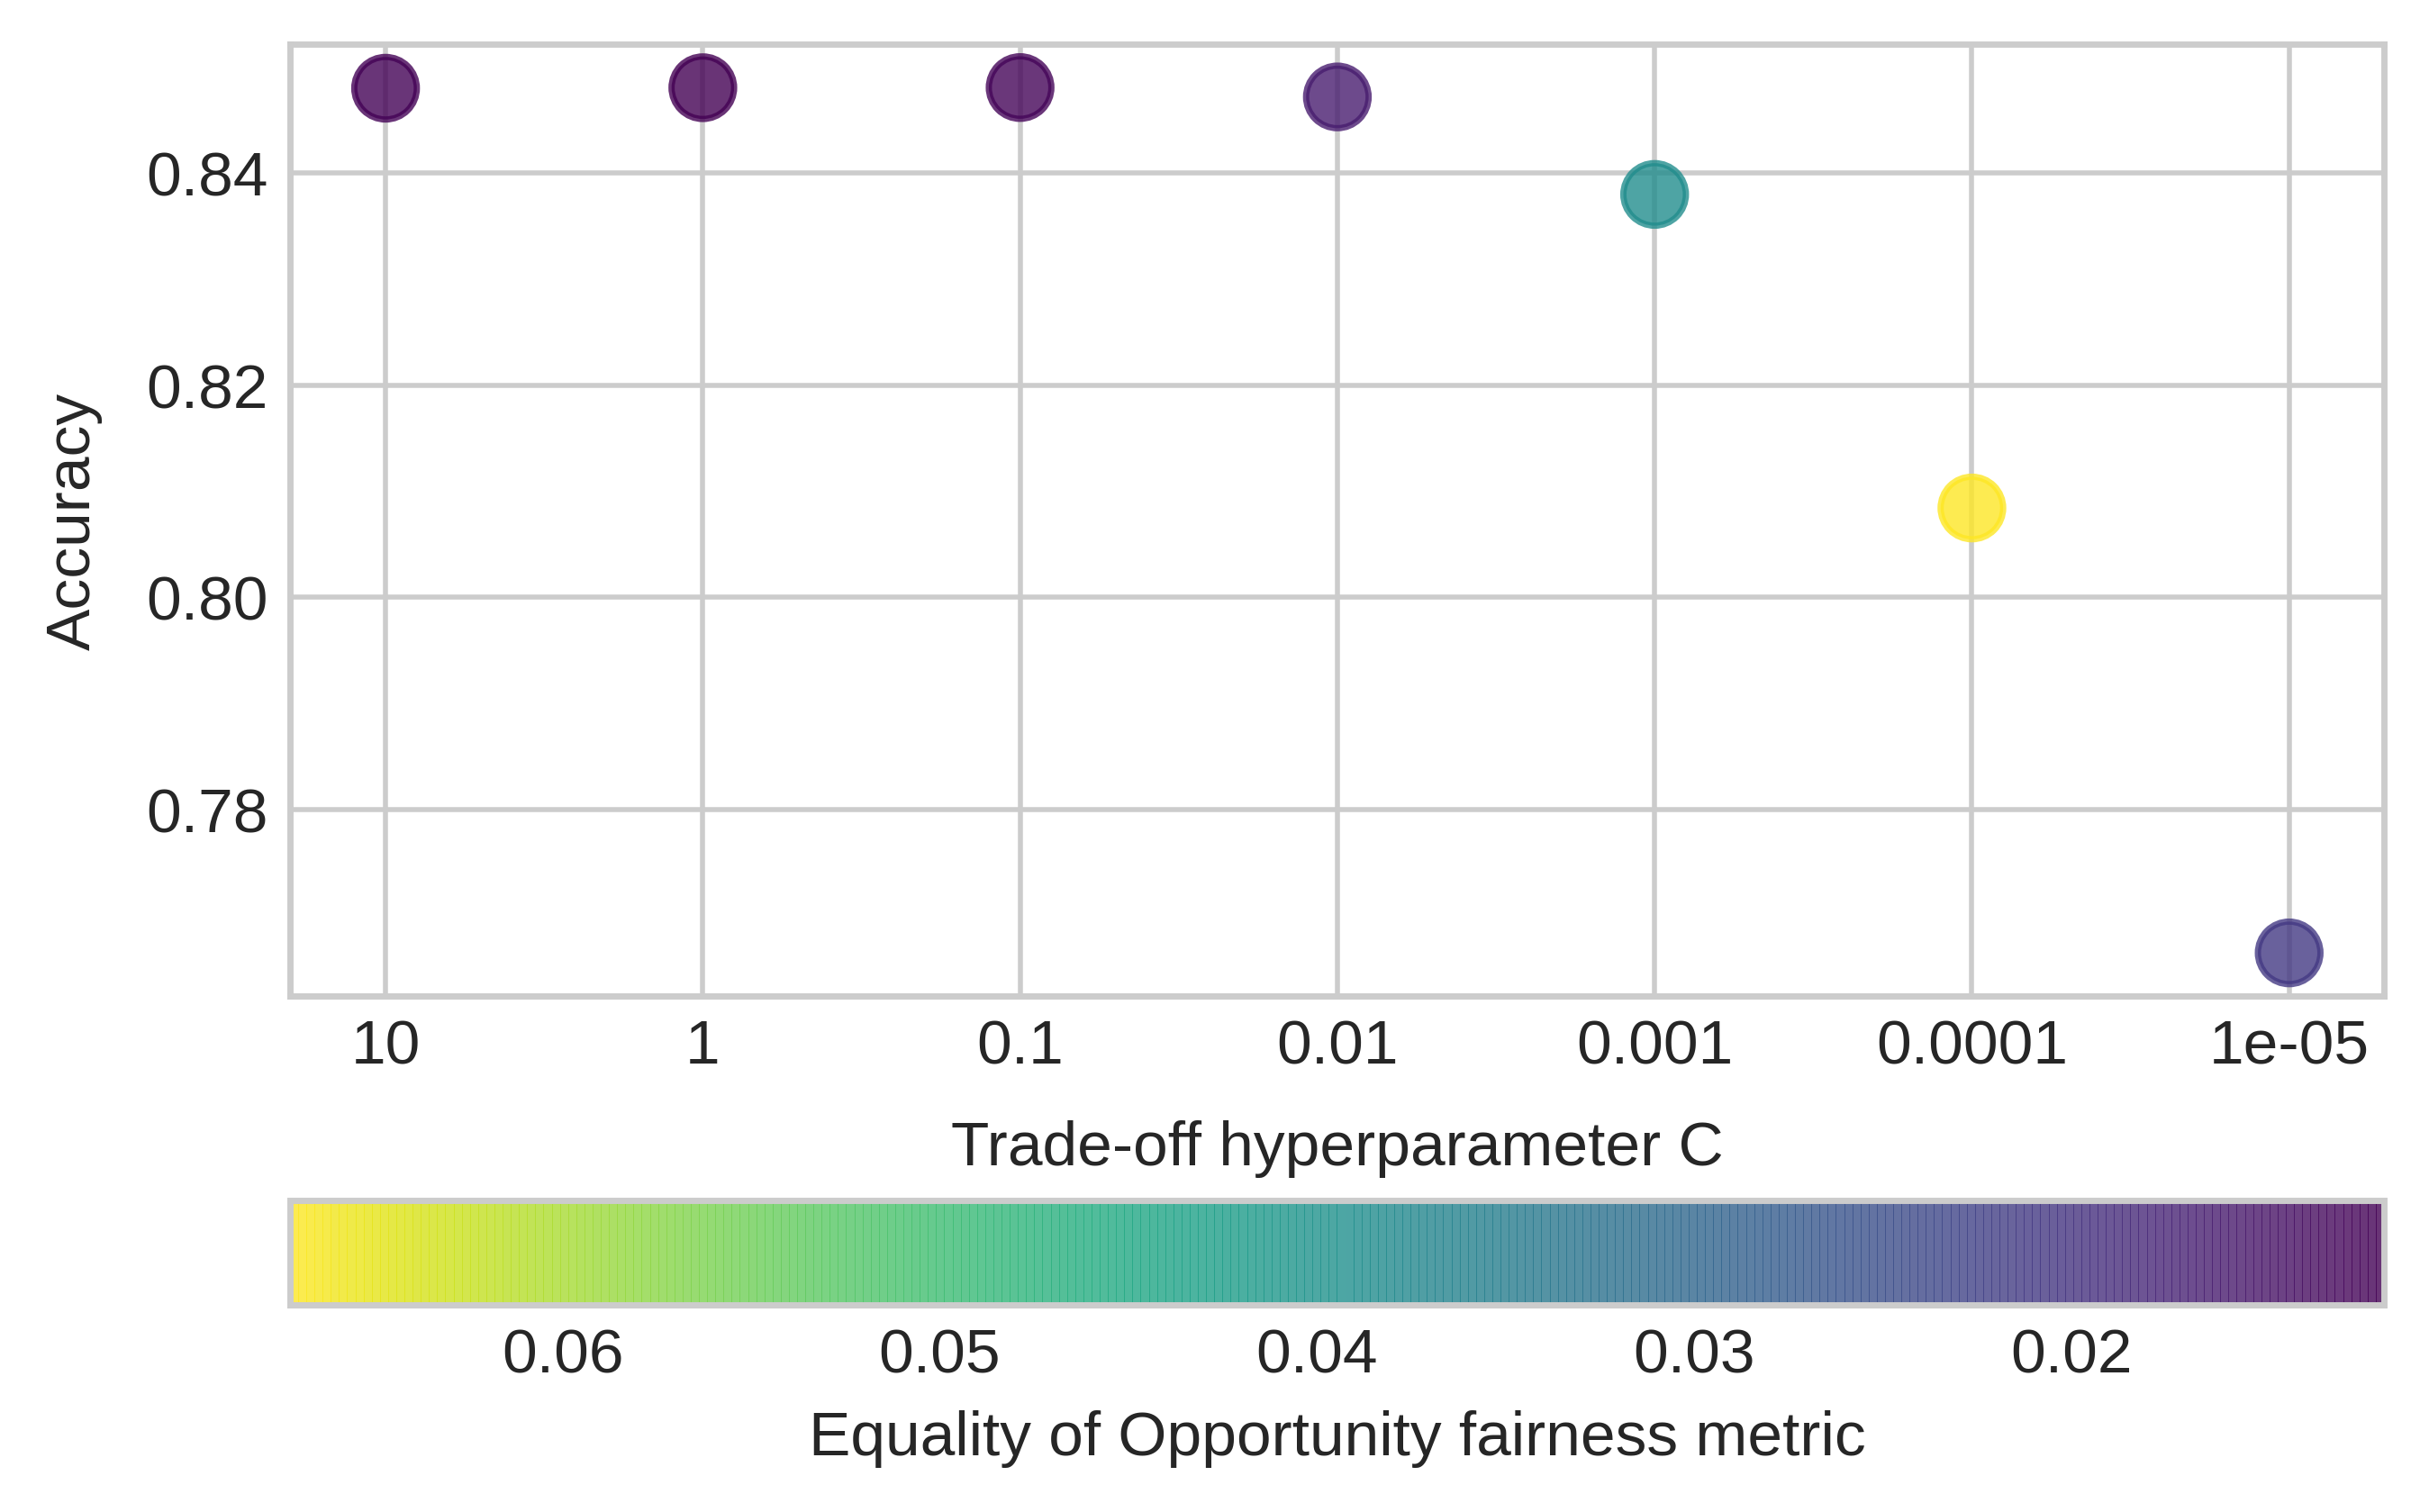

In [ ]:
plotGraph(modelListT1)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 0.1
Test Set Accuracy 0.8443650033168718
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.002004159611794454}


In [ ]:
#Best fairness model
getBestFarinessModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 1
Test Set Accuracy 0.8448072528930494
Fairness metrics on test set {'sex_Male_0-sex_Male_1': 0.002283397134593468}


In [ ]:
weights = em.compute_instance_weights(train)
weights

,instance weights
0,0.998568
1,1.004422
2,0.995591
3,1.001444
4,1.001444
...,...
63305,1.001444
63306,0.998568
63307,1.004422
63308,0.995591


In [ ]:
#Since the weights are almost equal for all datapoints, we do not need task 2 and task 3 as the best accuracy model is also the most fair.

#Crime Dataset

##Dataset imports

In [ ]:
dataset = em.crime(split='Race-Binary')
data = dataset.load()
train, test = em.train_test_split(data, train_percentage=0.7)
scale_orig = StandardScaler()
train.x[dataset.continuous_features] = scale_orig.fit_transform(train.x[dataset.continuous_features])
test.x[dataset.continuous_features] = scale_orig.transform(test.x[dataset.continuous_features])

X_train, y_train = TrainTestSplit(train,'high_crime')
X_test, y_test = TrainTestSplit(test, 'high_crime')

df=pd.DataFrame()
for col in data.x.columns:
  df[col]=data.x[col]
df[data.s.columns[0]]=data.s[data.s.columns[0]]
df[data.y.columns[0]]=data.y[data.y.columns[0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

(array([1340.,    0.,  653.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

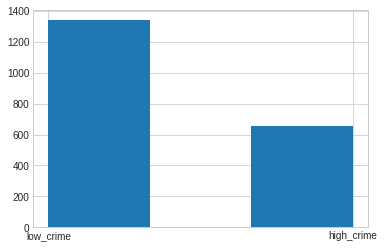

In [ ]:
crimeList=["high_crime" if s==1 else "low_crime" for s in data.y['high_crime']]
plt.hist(crimeList,bins=3)

(array([ 970.,    0., 1023.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

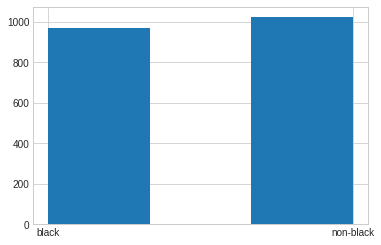

In [ ]:
raceList=["black" if s==1 else "non-black" for s in data.s['>0.06black']]
plt.hist(raceList,bins=3)

(array([888.,   0., 135.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

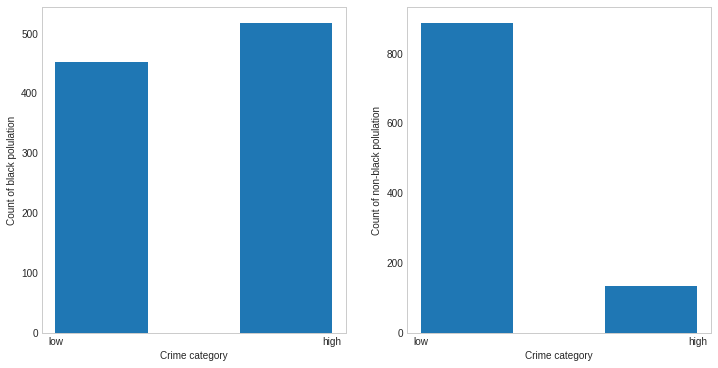

In [ ]:
from IPython.core.pylabtools import figsize
blackDf=df[df['>0.06black']==1]
blackcrimeList=["high" if s==1 else "low" for s in blackDf['high_crime']]
nonblackDf=df[df['>0.06black']==0]
femalesalaryList=["high" if s==1 else "low" for s in nonblackDf['high_crime']]

fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].set_ylabel("Count of black polulation")
ax[0].set_xlabel("Crime category")
ax[0].grid()
ax[0].hist(blackcrimeList,bins=3)
ax[1].set_ylabel("Count of non-black polulation")
ax[1].set_xlabel("Crime category")
ax[1].grid()
ax[1].hist(femalesalaryList,bins=3)

The above graph shows that the dataset is heavily skewed. The number of high crime rate for the black population is 3 times more than the non-black population.


##Task 1 (training with sensitive attribute)

In [ ]:
modelListT1 = crossValidationWithSenstiveAttribute(X_train, y_train, sensitiveAttribute='>0.06black')
print(modelListT1)

[(0.8473118279569892, 0.32985317901243116, 10), (0.8551971326164874, 0.2711074930516773, 1), (0.85663082437276, 0.2296132512988894, 0.1), (0.845878136200717, 0.15575641155789569, 0.01), (0.8114695340501793, 0.16642847601629704, 0.001), (0.7734767025089605, 0.2201269709561918, 0.0001), (0.7634408602150538, 0.2203869926246642, 1e-05)]


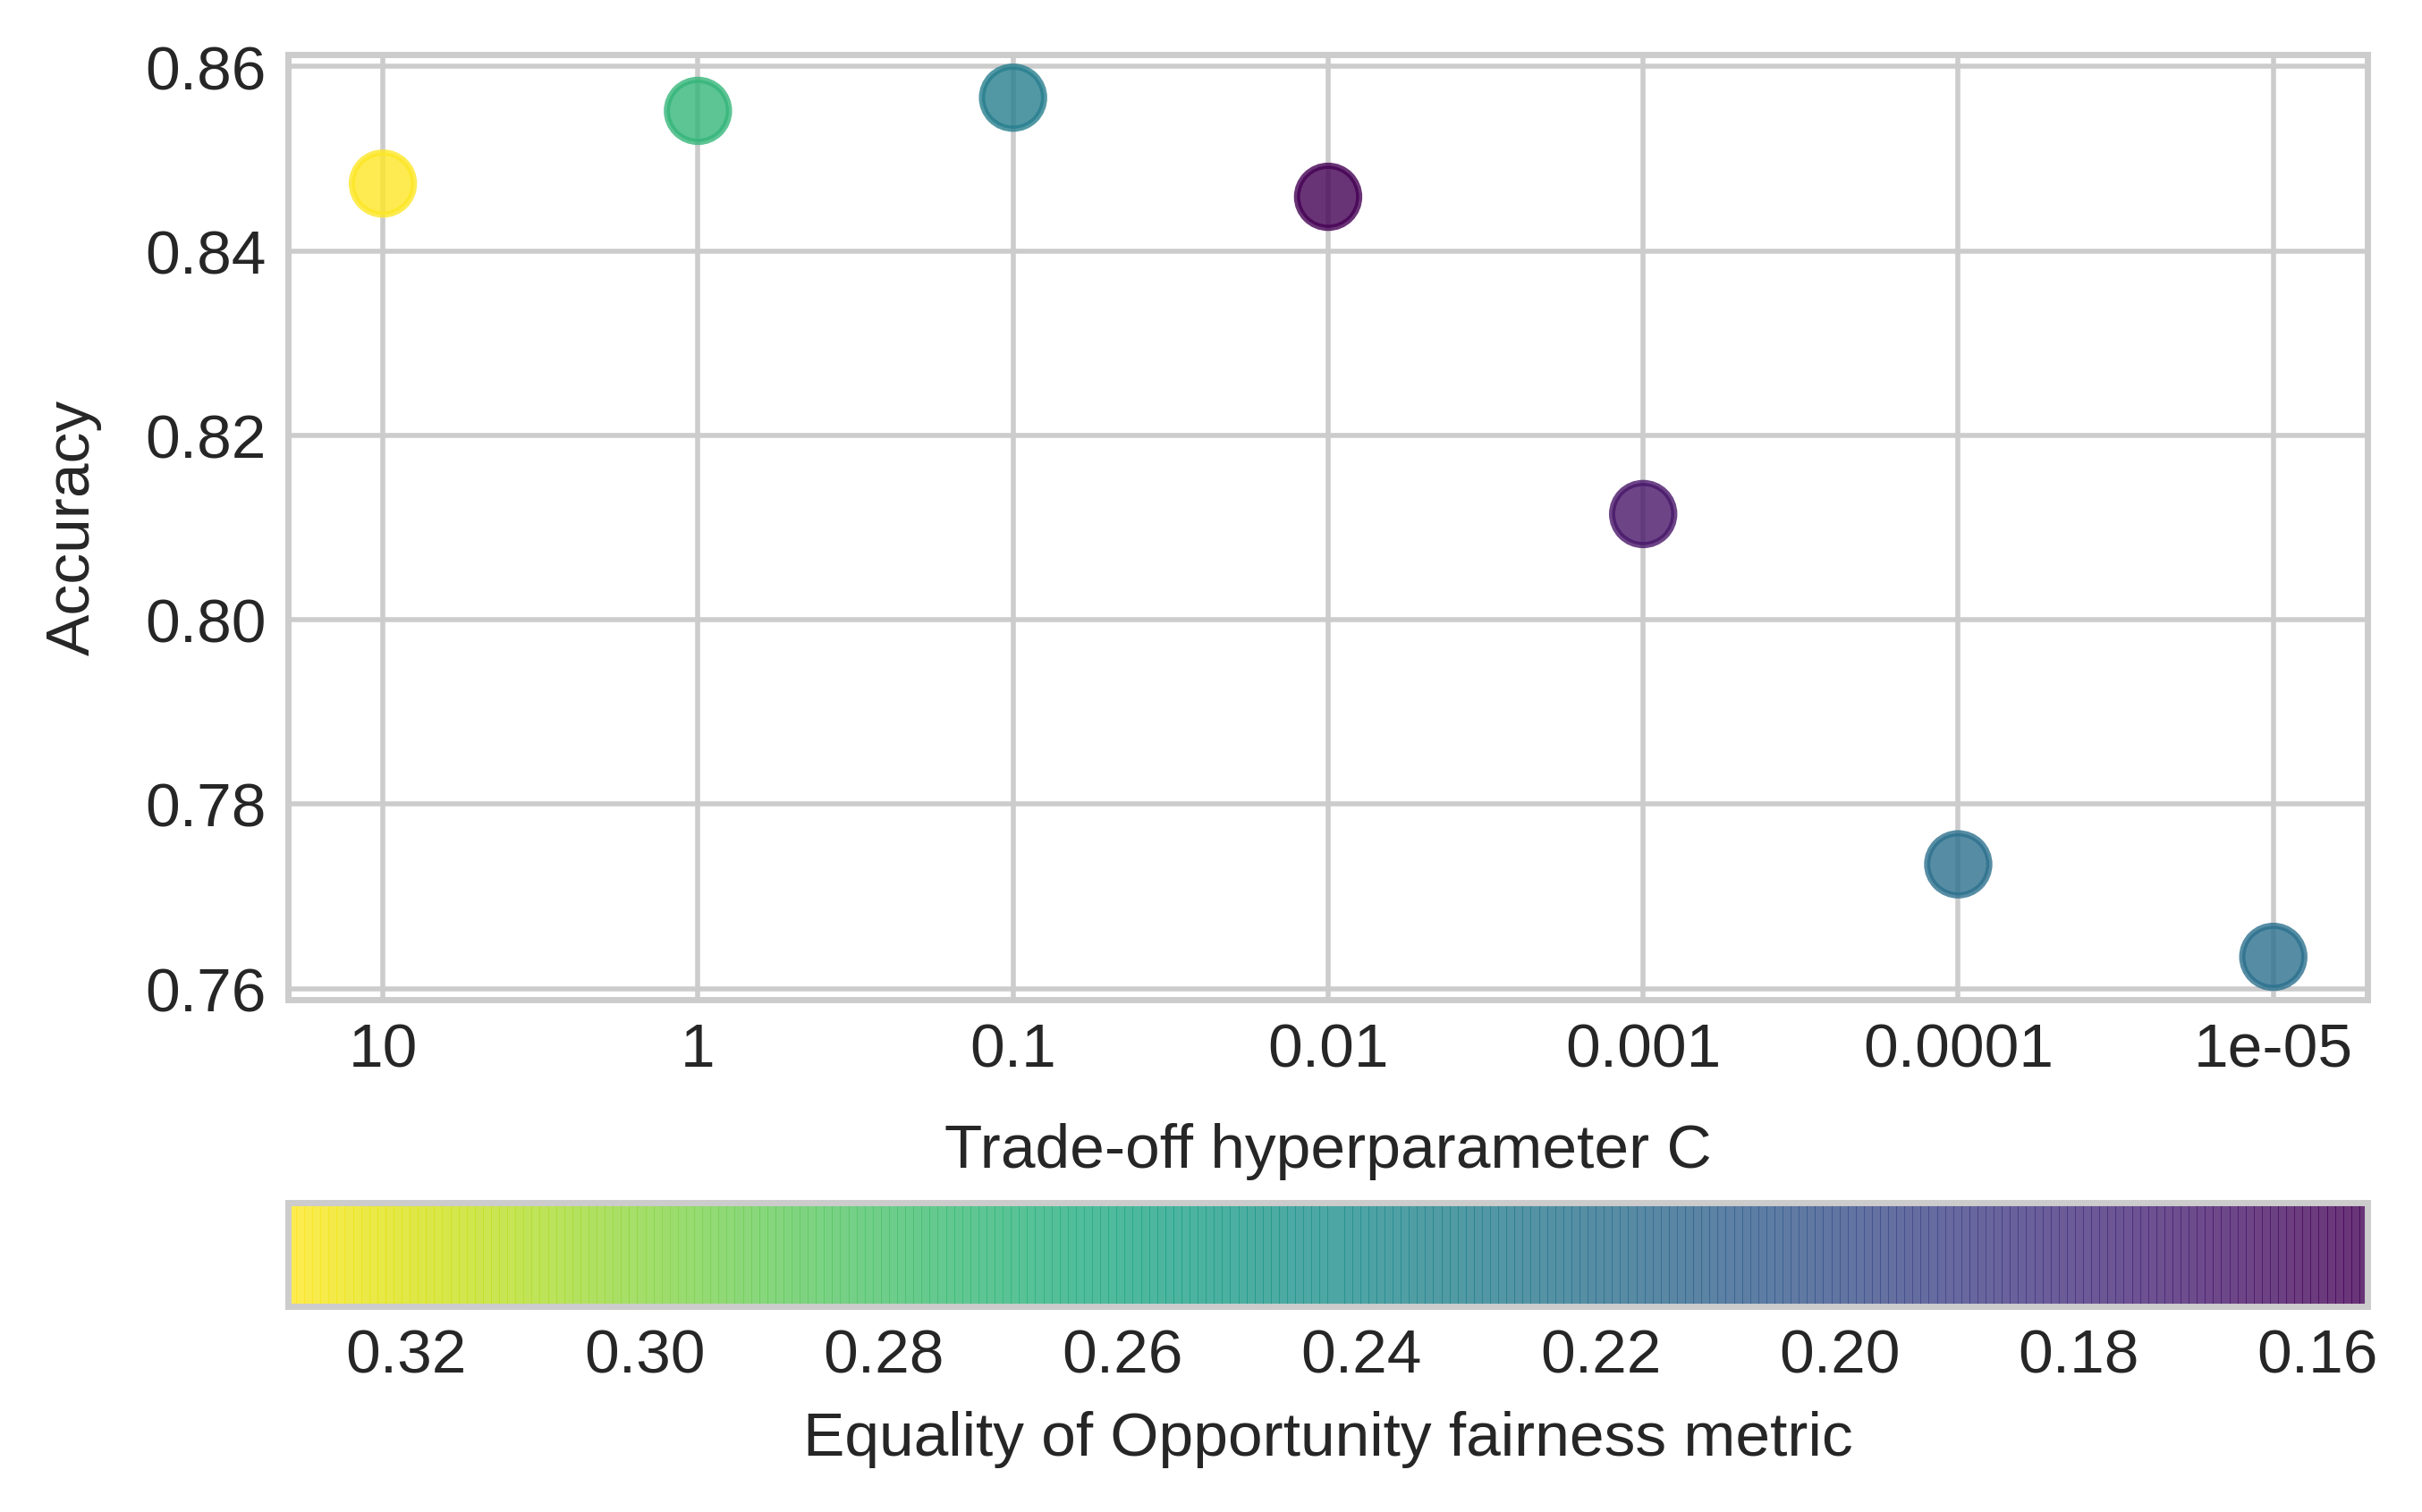

In [ ]:
plotGraph(modelListT1)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 0.1
Test Set Accuracy 0.8444816053511706
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.3122474747474748}


In [ ]:
#Best fairness model
getBestFarinessModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 0.01
Test Set Accuracy 0.842809364548495
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.2621212121212121}


The results suggest that the best fairness model is less accurate but better generalized. Hence it is more fair than the best accuracy model.

##Task2 Reweighing (training with sensitive attributes)

In [ ]:
#Reweighing the dataset

In [ ]:
weights=em.compute_instance_weights(train)

In [ ]:
weights.head()

,instance weights
0,1.416754
1,0.787704
2,0.787704
3,0.787704
4,1.416754


In [ ]:
modelListT2 = crossValidationWithSenstiveAttribute(X_train, y_train, sensitiveAttribute='>0.06black', weights=weights)
print(modelListT2)

[(0.8329749103942652, 0.12262313087454473, 10), (0.8372759856630825, 0.10585049565741904, 1), (0.8372759856630824, 0.11173624316639694, 0.1), (0.8344086021505376, 0.10605838192002234, 0.01), (0.8172043010752688, 0.07540549715804568, 0.001), (0.7985663082437277, 0.1671459057774392, 0.0001), (0.7777777777777777, 0.20701518682319087, 1e-05)]


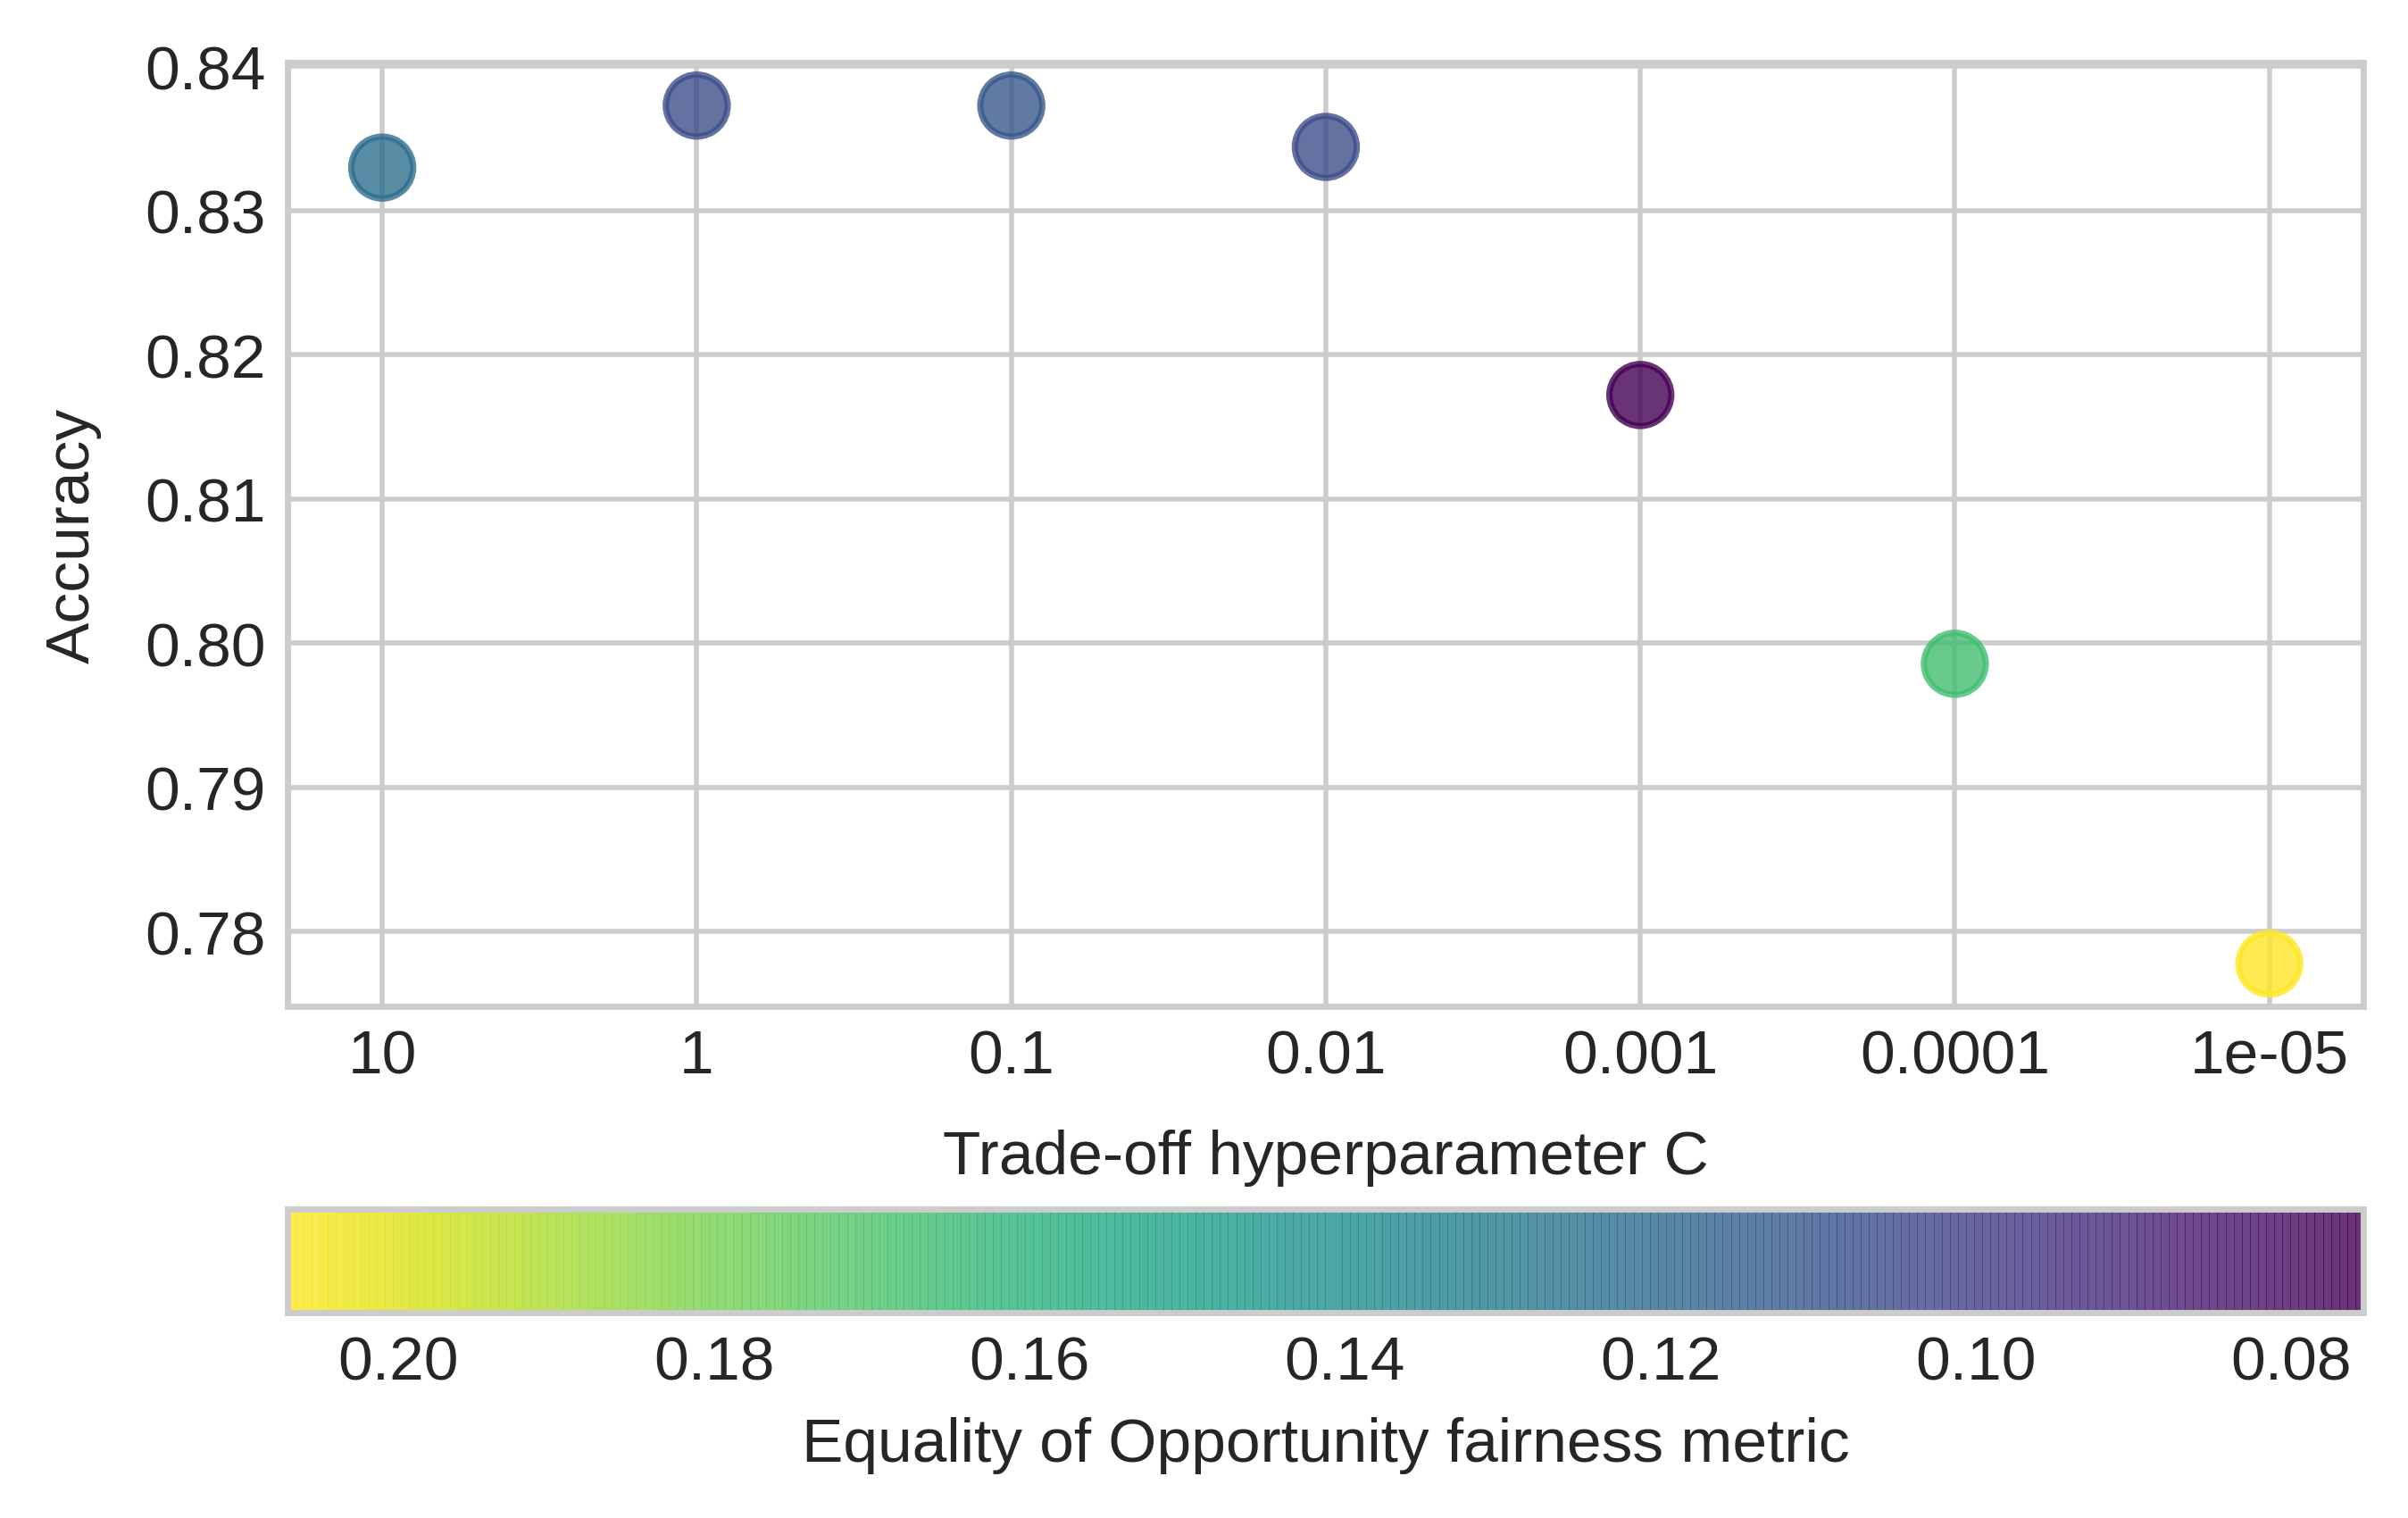

In [ ]:
plotGraph(modelListT2)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT2, weights)

Model with hyperparameter C = 1
Test Set Accuracy 0.8193979933110368
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.02083333333333337}


In [ ]:
#Best fairness model
getBestFarinessModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT2, weights)

Model with hyperparameter C = 0.001
Test Set Accuracy 0.8110367892976589
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.19027777777777777}


##Task 3 (trained with sensitive attributes) accounting for both accuracy and fairness criteria:
Subtract accuracy of both standrad and fairness based model and multiply with the difference of fairness of both the models for each hyperparameter. Finally, select the hyperparameter with the highest value and the model with fairness closest to zero.

In [ ]:
getBestAccuracyAndFairnessWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1, modelListT2, weights)

Models with hyperparameter C = 10
Standard ML Model (5) test Accuracy 0.8344481605351171
Standard ML Model (5) fairness metrics on test set {'>0.06black_0->0.06black_1': 0.3236111111111111}
Fairness based ML Model (6) test Accuracy 0.8244147157190636
Fairness based ML Model (6) fairness metrics on test set {'>0.06black_0->0.06black_1': 0.0601010101010101}


##Task 1 (training without sensitive attribute)

In [ ]:
modelListT1 = crossValidationWithoutSenstiveAttribute(train)
print(modelListT1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[(0.8508960573476703, 0.270733887183943, 10), (0.8594982078853046, 0.22421013068116918, 1), (0.8559139784946236, 0.1999147660011822, 0.1), (0.8451612903225806, 0.16165023604326945, 0.01), (0.8143369175627241, 0.18619621573108477, 0.001), (0.7720430107526882, 0.2201269709561918, 0.0001), (0.7634408602150538, 0.2203869926246642, 1e-05)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


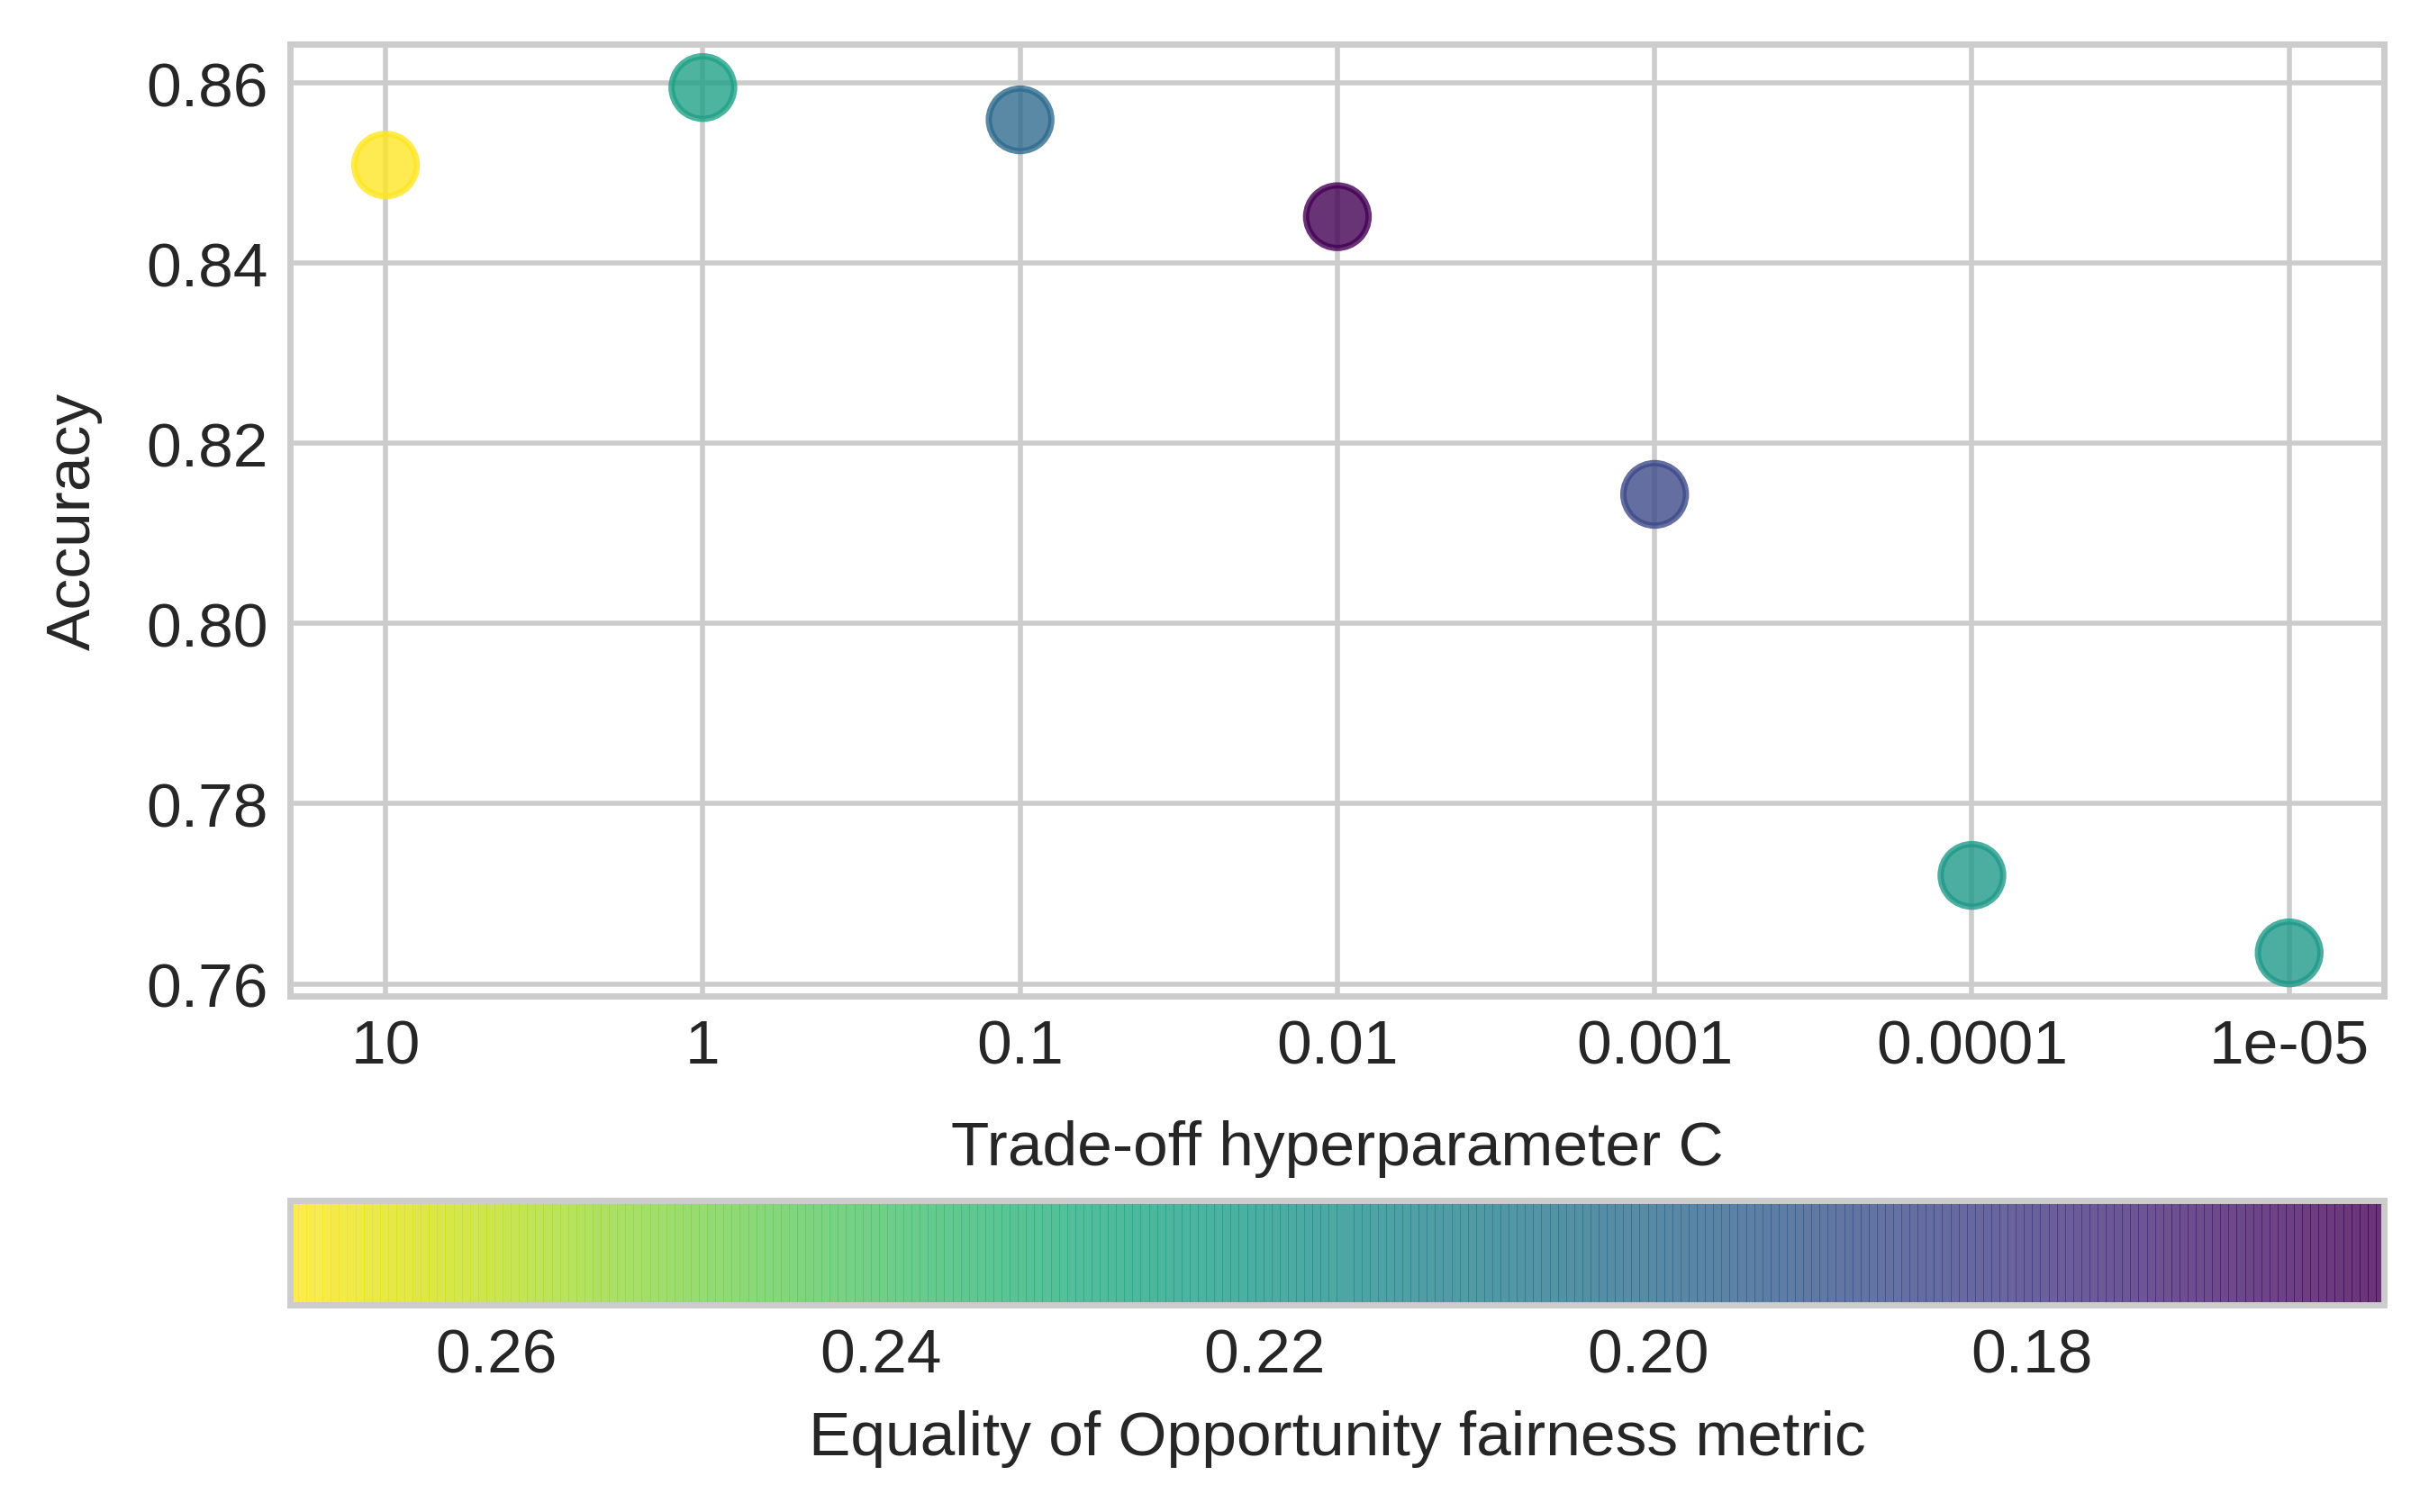

In [ ]:
plotGraph(modelListT1)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithoutSenstiveAttribute(train, test, modelListT1)

Model with hyperparameter C = 1
Test Set Accuracy 0.8260869565217391
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.28952020202020207}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Best fairness model
getBestFarinessModelWithoutSenstiveAttribute(train, test, modelListT1)

Model with hyperparameter C = 0.01
Test Set Accuracy 0.842809364548495
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.2621212121212121}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Task2 Reweighing (training without sensitive attributes)

In [ ]:
modelListT2 = crossValidationWithoutSenstiveAttribute(train, weights=weights)
print(modelListT2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[(0.8351254480286737, 0.12096807863557982, 10), (0.8415770609318995, 0.1113359426436225, 1), (0.8480286738351255, 0.06767402343183113, 0.1), (0.8372759856630825, 0.13148901866797474, 0.01), (0.8179211469534049, 0.11106011534463316, 0.001), (0.7949820788530466, 0.1671459057774392, 0.0001), (0.7763440860215053, 0.21299066062475164, 1e-05)]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


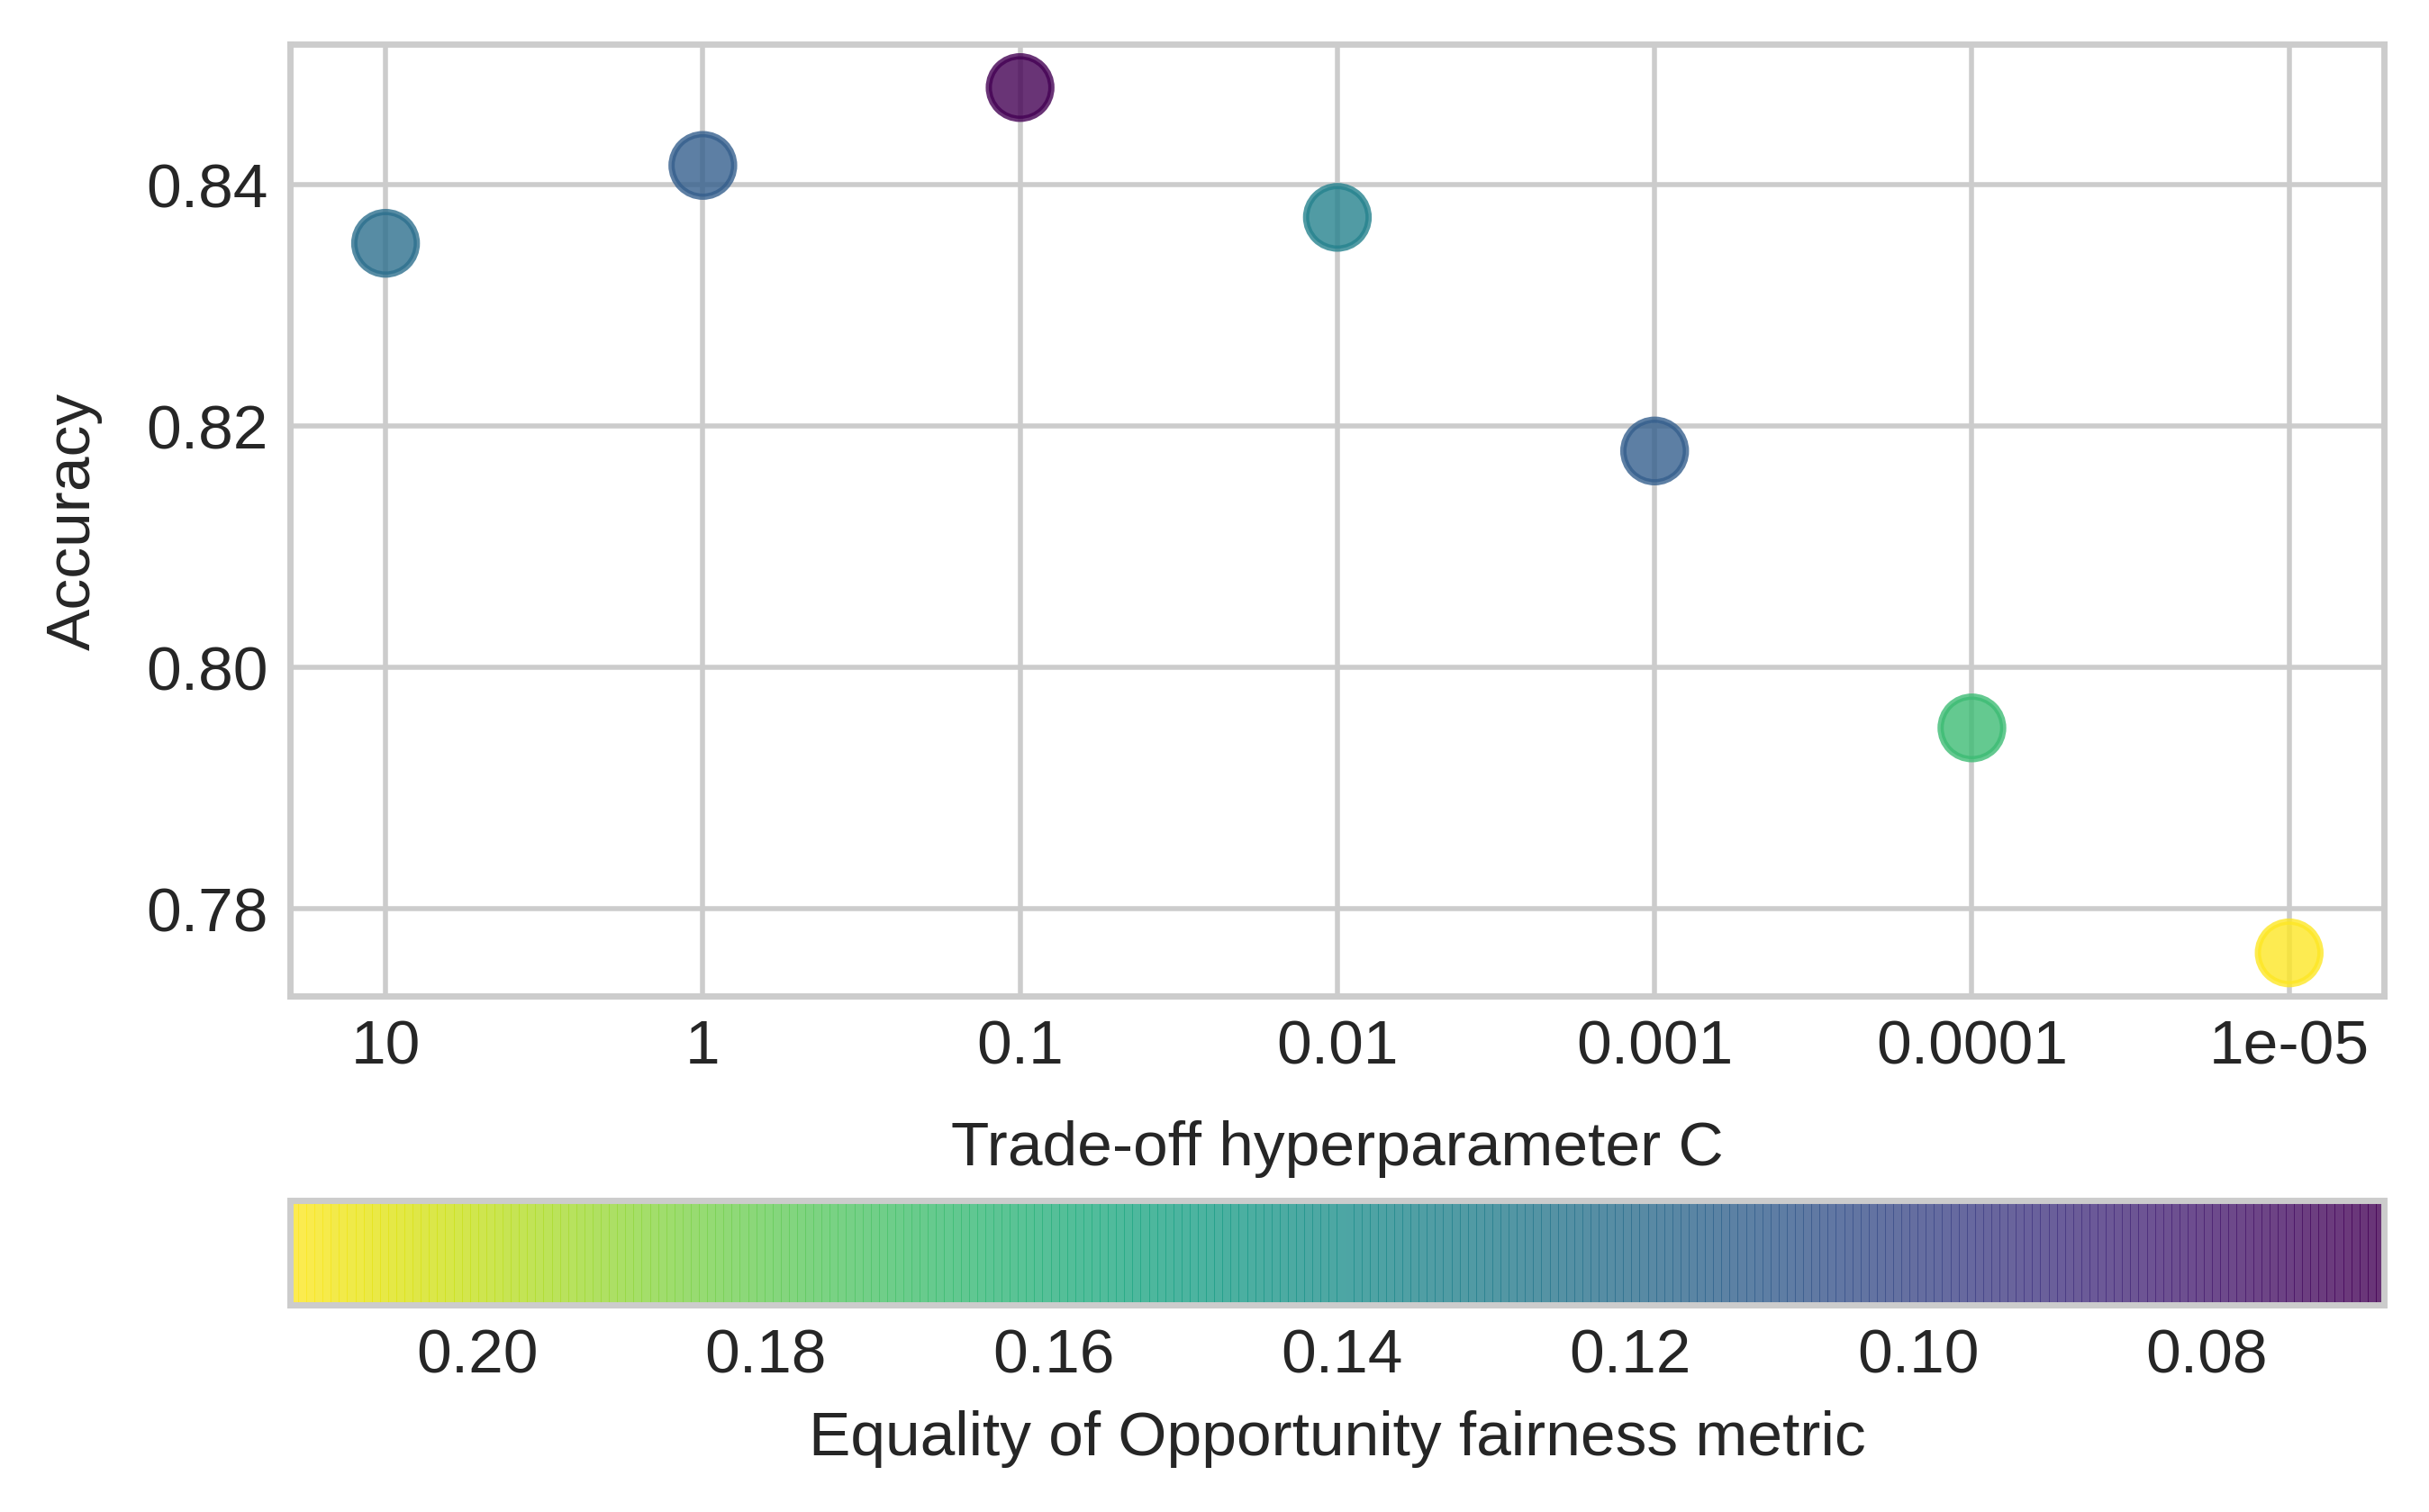

In [ ]:
plotGraph(modelListT2)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithoutSenstiveAttribute(train, test, modelListT2, weights)

Model with hyperparameter C = 0.1
Test Set Accuracy 0.8210702341137124
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.08232323232323235}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Best fairness model
getBestFarinessModelWithoutSenstiveAttribute(train, test, modelListT2, weights)

Model with hyperparameter C = 0.1
Test Set Accuracy 0.8210702341137124
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.08232323232323235}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Task 3 (trained without sensitive attributes) accounting for both accuracy and fairness criteria:
Subtract accuracy of both standrad and fairness based model and multiply with the difference of fairness of both the models for each hyperparameter. Finally, select the hyperparameter with the highest value and the model with fairness closest to zero.

In [ ]:
getBestAccuracyAndFairnessWithoutSenstiveAttribute(train, test, modelListT1, modelListT2, weights)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Models with hyperparameter C = 10
Standard ML Model (5) test Accuracy 0.8277591973244147
Standard ML Model (5) fairness metrics on test set {'>0.06black_0->0.06black_1': 0.3008838383838384}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fairness based ML Model (6) test Accuracy 0.8160535117056856
Fairness based ML Model (6) fairness metrics on test set {'>0.06black_0->0.06black_1': 0.11590909090909096}


#Extra task: Counterfactual Augmentation on Crime Dataset

##Dataset Manuplulation

In [14]:
dataset = em.crime(split='Race-Binary')
data = dataset.load()

In [15]:
df=pd.DataFrame()
for col in data.x.columns:
  df[col]=data.x[col]
df[data.s.columns[0]]=data.s[data.s.columns[0]]
df[data.y.columns[0]]=data.y[data.y.columns[0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [16]:
df_out = df.copy()
df_out['>0.06black'] = df_out['>0.06black'].apply(lambda value: 1-value)
result = pd.concat([df.copy(), df_out])

(array([2680.,    0., 1306.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

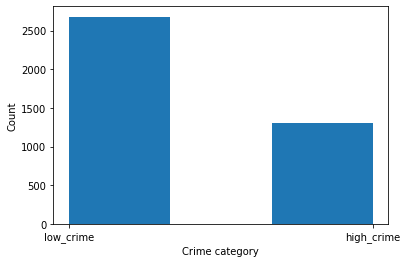

In [17]:
crimeList=["high_crime" if s==1 else "low_crime" for s in result['high_crime']]
plt.xlabel('Crime category')
plt.ylabel('Count')
plt.hist(crimeList,bins=3)

(array([1993.,    0., 1993.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

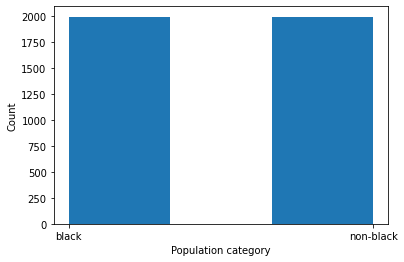

In [18]:
raceList=["black" if s==1 else "non-black" for s in result['>0.06black']]
plt.xlabel('Population category')
plt.ylabel('Count')
plt.hist(raceList,bins=3)

(array([1340.,    0.,  653.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

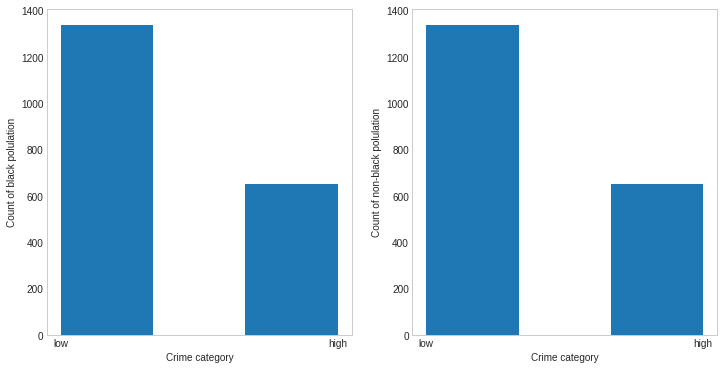

In [ ]:
from IPython.core.pylabtools import figsize
blackDf=result[result['>0.06black']==1]
blackcrimeList=["high" if s==1 else "low" for s in blackDf['high_crime']]
nonblackDf=result[result['>0.06black']==0]
femalesalaryList=["high" if s==1 else "low" for s in nonblackDf['high_crime']]

fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].set_ylabel("Count of black polulation")
ax[0].set_xlabel("Crime category")
ax[0].grid()
ax[0].hist(blackcrimeList,bins=3)
ax[1].set_ylabel("Count of non-black polulation")
ax[1].set_xlabel("Crime category")
ax[1].grid()
ax[1].hist(femalesalaryList,bins=3)

Dataset is balanced

In [ ]:
cfData = em.DataTuple(pd.DataFrame(result.drop(labels=['>0.06black'],axis=1).drop(labels=['high_crime'],axis=1)).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(result['>0.06black']).reset_index().drop(labels=['index'],axis=1), pd.DataFrame(result['high_crime']).reset_index().drop(labels=['index'],axis=1))

In [ ]:
train, test = em.train_test_split(cfData, train_percentage=0.7)
scale_orig = StandardScaler()
train.x[dataset.continuous_features] = scale_orig.fit_transform(train.x[dataset.continuous_features])
test.x[dataset.continuous_features] = scale_orig.transform(test.x[dataset.continuous_features])

X_train, y_train = TrainTestSplit(train, 'high_crime')
X_test, y_test = TrainTestSplit(test, 'high_crime')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1


##Task 1 (training with sensitive attribute)

In [ ]:
modelListT1 = crossValidationWithSenstiveAttribute(X_train, y_train, sensitiveAttribute='>0.06black')
print(modelListT1)

[(0.867741935483871, 0.022087622199047453, 10), (0.8652329749103942, 0.04832747086947471, 1), (0.8641577060931901, 0.04229980339330104, 0.1), (0.8548387096774194, 0.07811159055952484, 0.01), (0.8297491039426523, 0.06829763501600375, 0.001), (0.7978494623655912, 0.05046136011443307, 0.0001), (0.7738351254480287, 0.05769351095544939, 1e-05)]


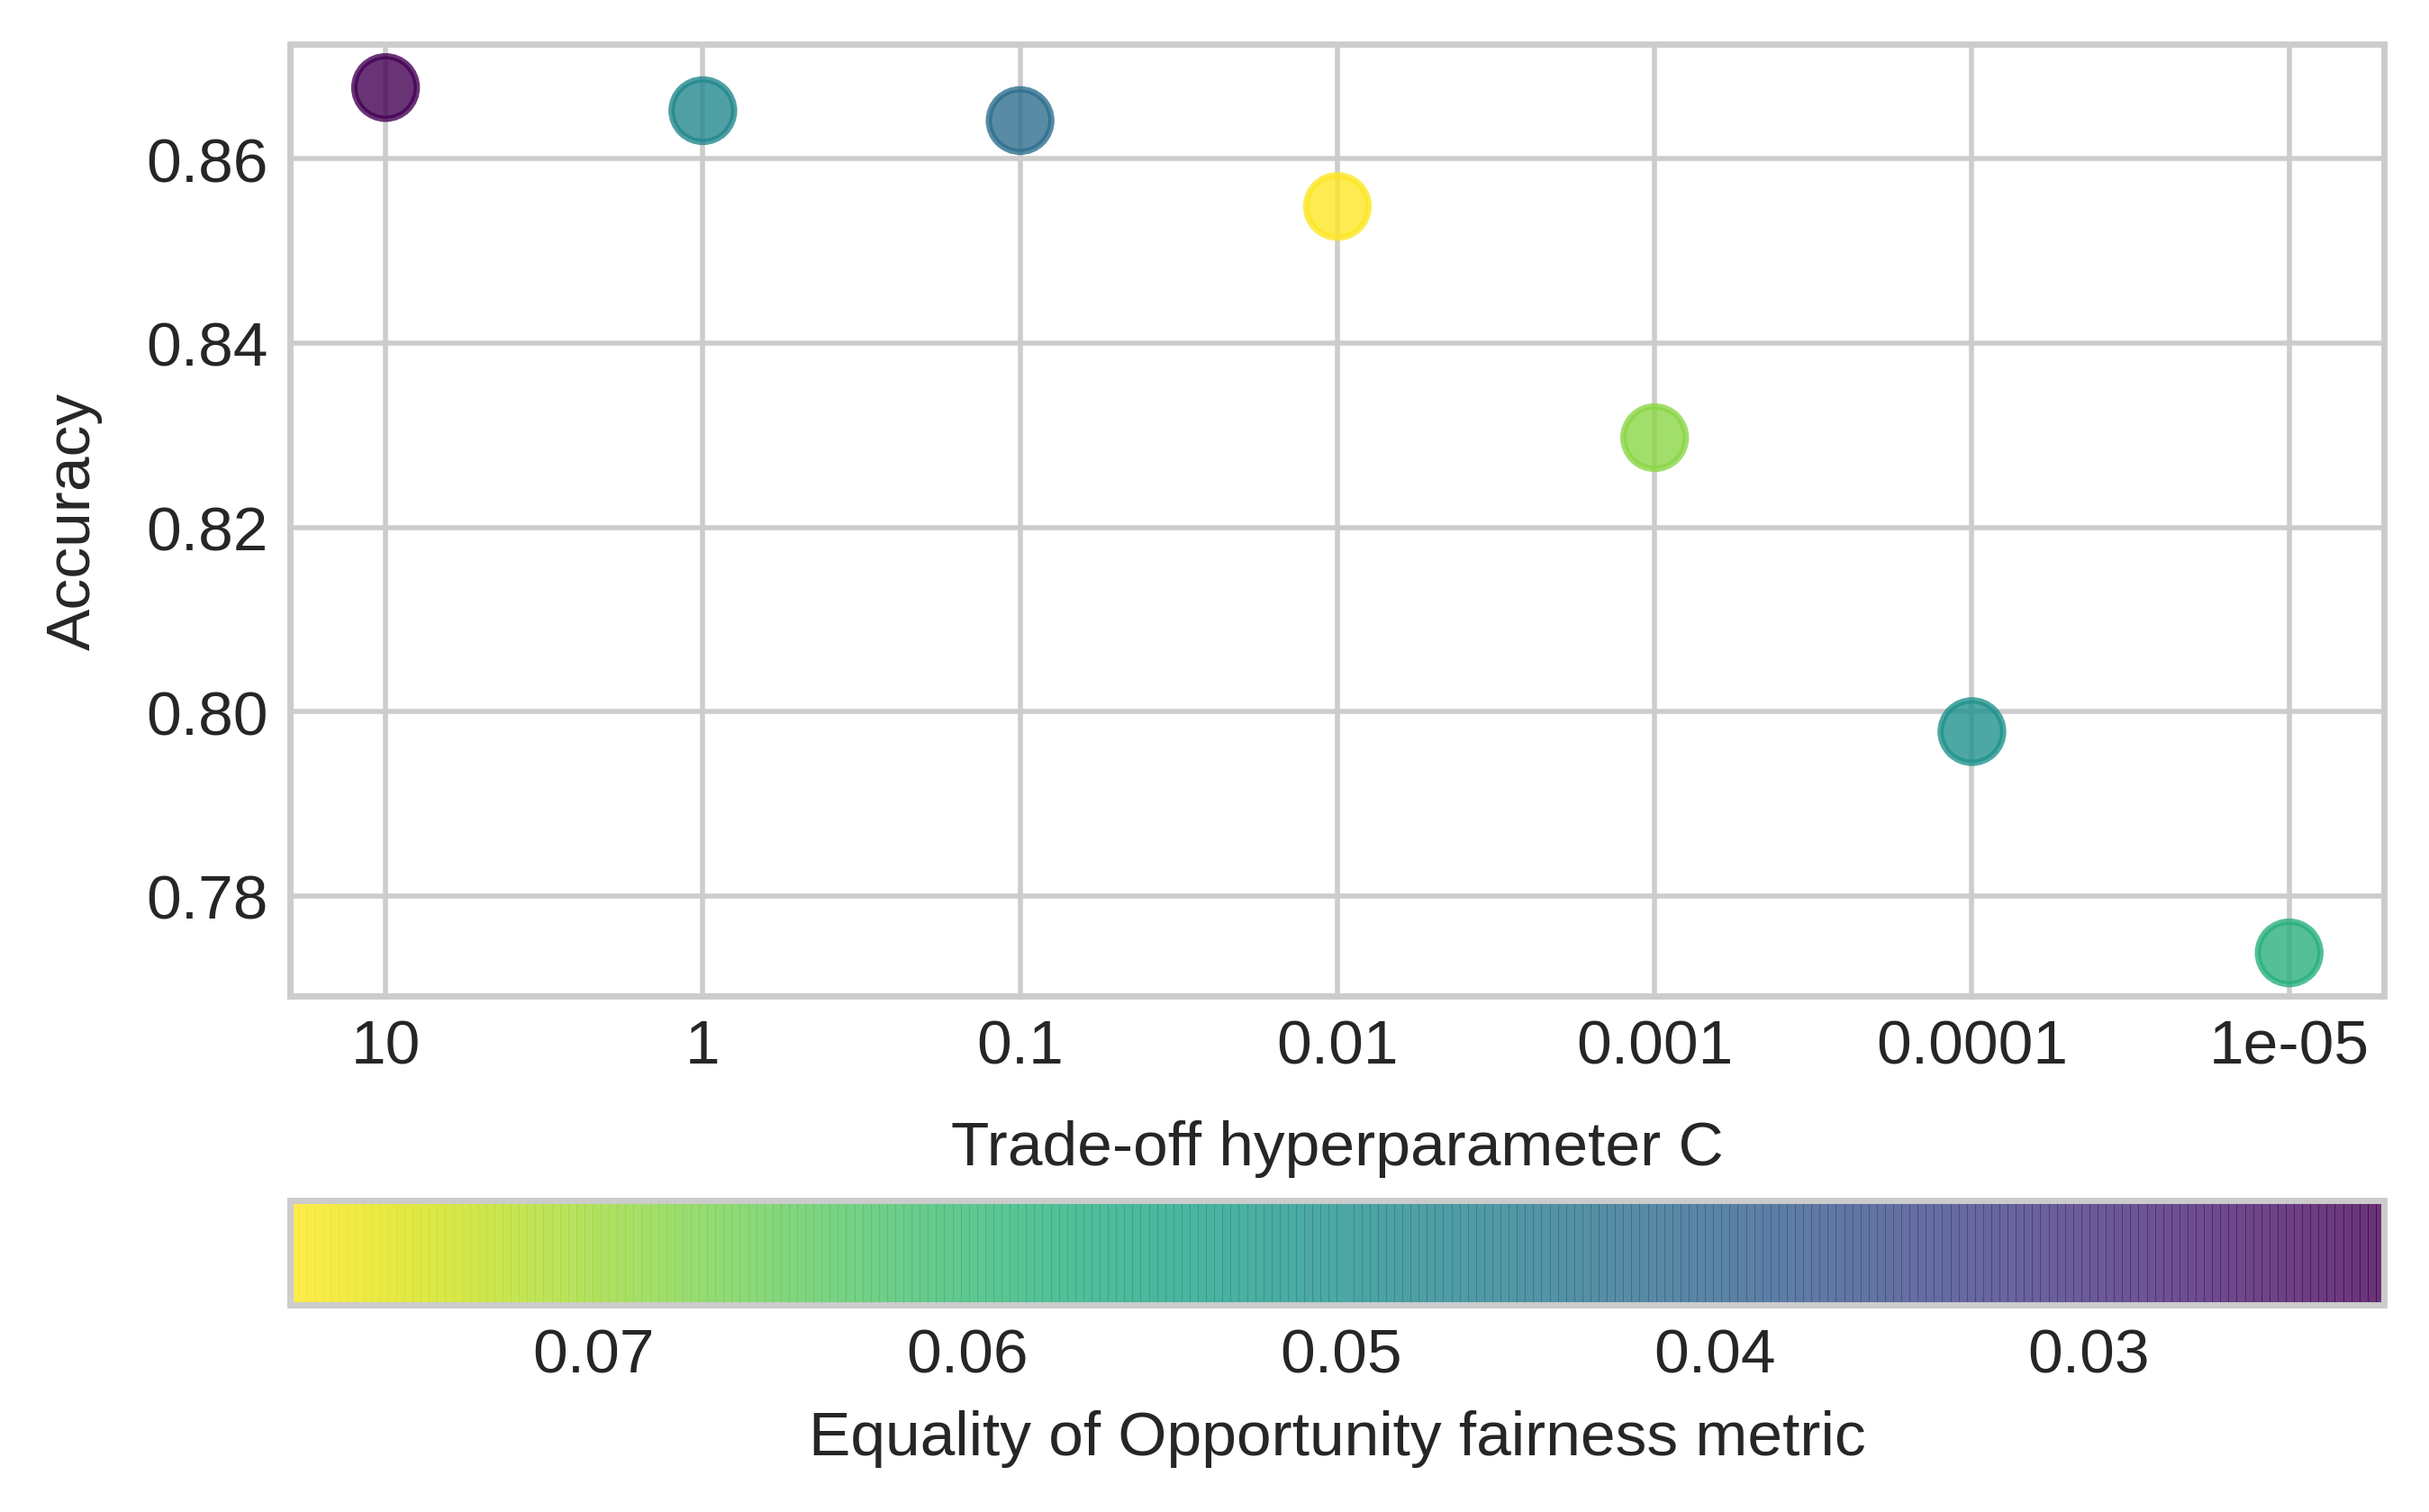

In [ ]:
plotGraph(modelListT1)

In [ ]:
#Best accuracy model
getBestAccuracyModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 10
Test Set Accuracy 0.8536789297658863
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.0498347448874199}


In [ ]:
#Best fairness model
getBestFarinessModelWithSenstiveAttribute(X_train, y_train, X_test, y_test, modelListT1)

Model with hyperparameter C = 10
Test Set Accuracy 0.8536789297658863
Fairness metrics on test set {'>0.06black_0->0.06black_1': 0.0498347448874199}


In [ ]:
weights = em.compute_instance_weights(train)
weights

,instance weights
0,1.002584
1,1.001211
2,0.998750
3,0.998750
4,0.998750
...,...
2785,0.997516
2786,1.001211
2787,1.002584
2788,0.997516


In [ ]:
#Since the weights are almost equal for all datapoints, we do not need task 2 and task 3 as the best accuracy model is also the most fair.

#Tables

1. Adult Dataset (with sensitive)

|      Model    (#)     |      Description        |      Task     |      Hyperparameter     |      Test    Set Accuracy     |      Fairness    Metrics on Test Set                      |
|-----------------------|-------------------------|---------------|-------------------------|-------------------------------|-----------------------------------------------------------|
|     1                 |     Best   Accuracy     |     1         |     0.1                 |     0.847792438               |     {'sex_Male_0-sex_Male_1':   0.11064877472859735}      |
|     2                 |     Best   Fairness     |     1         |     1e-05               |     0.761480062               |     {'sex_Male_0-sex_Male_1':   0.0073602672272295305}    |
|     3                 |     Best   Accuracy     |     2         |     0.1                 |     0.844328149               |     {'sex_Male_0-sex_Male_1':   0.15302646355861438}      |
|     4                 |     Best   Fairness     |     2         |     1e-05               |     0.759637355               |     {'sex_Male_0-sex_Male_1':   0.004810378091974547}     |
|     5                 |     Standard            |     3         |     0.001               |     0.832534827               |     {'sex_Male_0-sex_Male_1':   0.2276154001209434}       |
|     6                 |     Fairness   Based    |     3         |     0.001               |     0.833640451               |     {'sex_Male_0-sex_Male_1':   0.039794684251447}        |

2. Adult Dataset (without sensitive)

|      Model    (#)     |      Description        |      Task     |      Hyperparameter     |      Test    Set Accuracy     |      Fairness    Metrics on Test Set                      |
|-----------------------|-------------------------|---------------|-------------------------|-------------------------------|-----------------------------------------------------------|
|     1                 |     Best   Accuracy     |     1         |     1                   |     0.84852952                |     {'sex_Male_0-sex_Male_1':   0.0865277737783281}       |
|     2                 |     Best   Fairness     |     1         |     1e-05               |     0.76369131                |     {'sex_Male_0-sex_Male_1':   0.021969936936677516}     |
|     3                 |     Best   Accuracy     |     2         |     10                  |     0.843738483               |     {'sex_Male_0-sex_Male_1':   0.13366112822875575}      |
|     4                 |     Best   Fairness     |     2         |     1e-05               |     0.762069728               |     {'sex_Male_0-sex_Male_1':   0.011193019840469949}     |
|     5                 |     Standard            |     3         |     0.001               |     0.832534827               |     {'sex_Male_0-sex_Male_1':   0.2276154001209434}       |
|     6                 |     Fairness   Based    |     3         |     0.001               |     0.834230117               |     {'sex_Male_0-sex_Male_1':   0.00347856134995822}      |

3. Crime Dataset (with sensitive)

|      Model    (#)     |      Description        |      Task     |      Hyperparameter     |      Test    Set Accuracy     |      Fairness    Metrics on Test Set                        |   |
|-----------------------|-------------------------|---------------|-------------------------|-------------------------------|-------------------------------------------------------------|---|
|     1                 |     Best   Accuracy     |     1         |     0.1                 |     0.844481605               |     {'>0.06black_0->0.06black_1':   0.3122474747474748}     |   |
|     2                 |     Best   Fairness     |     1         |     0.01                |     0.842809365               |     {'>0.06black_0->0.06black_1':   0.2621212121212121}     |   |
|     3                 |     Best   Accuracy     |     2         |     1                   |     0.819397993               |     {'>0.06black_0->0.06black_1':   0.02083333333333337}    |   |
|     4                 |     Best   Fairness     |     2         |     0.001               |     0.811036789               |     {'>0.06black_0->0.06black_1':   0.19027777777777777}    |   |
|     5                 |     Standard            |     3         |     10                  |     0.834448161               |     {'>0.06black_0->0.06black_1':   0.3236111111111111}     |   |
|     6                 |     Fairness   Based    |     3         |     10                  |     0.824414716               |     {'>0.06black_0->0.06black_1':   0.0601010101010101}     |   |

4. Crime Dataset (without sensitive)

|      Model    (#)     |      Description        |      Task     |      Hyperparameter     |      Test    Set Accuracy     |      Fairness    Metrics on Test Set                        |   |
|-----------------------|-------------------------|---------------|-------------------------|-------------------------------|-------------------------------------------------------------|---|
|     1                 |     Best   Accuracy     |     1         |     1                   |     0.826086957               |     {'>0.06black_0->0.06black_1':   0.28952020202020207}    |   |
|     2                 |     Best   Fairness     |     1         |     0.01                |     0.842809365               |     {'>0.06black_0->0.06black_1':   0.2621212121212121}     |   |
|     3                 |     Best   Accuracy     |     2         |     0.1                 |     0.821070234               |     {'>0.06black_0->0.06black_1':   0.08232323232323235}    |   |
|     4                 |     Best   Fairness     |     2         |     0.1                 |     0.821070234               |     {'>0.06black_0->0.06black_1':   0.08232323232323235}    |   |
|     5                 |     Standard            |     3         |     10                  |     0.827759197               |     {'>0.06black_0->0.06black_1':   0.3008838383838384}     |   |
|     6                 |     Fairness   Based    |     3         |     10                  |     0.816053512               |     {'>0.06black_0->0.06black_1':   0.11590909090909096}    |   |